In [1]:
# =====================================================================================
# Cell 1: Project Setup for "Quantum-Inspired GNN for Commodity-Equity Contagion"
#
# This script performs all necessary setup tasks with a focus on stability:
# 1. Validates the presence of the Kaggle API key.
# 2. Forces a clean re-installation of PyTorch and PyG to resolve potential
#    CUDA library/driver conflicts by targeting a more stable CUDA version (11.8).
# 3. Downloads and unzips the financial dataset.
# 4. Verifies GPU access.
# =====================================================================================

import os
import sys
import subprocess
import importlib.util

# Define the absolute path to your kaggle.json file
KAGGLE_API_KEY_PATH = '/notebooks/kaggle.json'

# --- Step 1: Validate Kaggle API Key ---
print(f"--- [1/6] Searching for Kaggle API key at: {KAGGLE_API_KEY_PATH} ---")
if not os.path.exists(KAGGLE_API_KEY_PATH):
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"!!! CRITICAL ERROR: '{KAGGLE_API_KEY_PATH}' NOT FOUND.       !!!")
    print("!!! Please ensure the kaggle.json file exists at this exact !!!")
    print("!!! path and run this cell again.                           !!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    sys.exit(f"Execution stopped. Cannot find {KAGGLE_API_KEY_PATH}.")
else:
    print("✅ SUCCESS: Kaggle API key found.\n")


def run_command(command):
    """Runs a shell command and prints its output live."""
    print(f"▶️ Executing: {command}")
    process = subprocess.Popen(
        command,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    for line in iter(process.stdout.readline, ''):
        print(line, end='', flush=True)
    process.stdout.close()
    return_code = process.wait()
    if return_code:
        print(f"\n❌ ERROR: Command failed with exit code {return_code}")
        raise subprocess.CalledProcessError(return_code, command)
    print("✅ Command finished successfully.\n")


try:
    # --- Step 2: Configure Kaggle Environment ---
    print("--- [2/6] Configuring Kaggle API key permissions ---")
    kaggle_dir = os.path.expanduser('~/.kaggle')
    os.makedirs(kaggle_dir, exist_ok=True)
    destination_file = os.path.join(kaggle_dir, 'kaggle.json')
    run_command(f'cp "{KAGGLE_API_KEY_PATH}" "{destination_file}"')
    run_command(f'chmod 600 "{destination_file}"')

    # --- Step 3: Force Re-installation of Python Packages for GPU Stability ---
    print("--- [3/6] Forcing clean re-installation of PyTorch and dependencies ---")

    # Step 3a: Aggressively uninstall existing versions to prevent conflicts.
    print("--- [3a] Uninstalling existing PyTorch-related packages... ---")
    uninstall_packages = [
        "torch", "torchvision", "torchaudio",
        "torch_geometric", "torch-scatter", "torch-sparse"
    ]
    run_command(f"pip uninstall -y {' '.join(uninstall_packages)} || true")

    # Step 3b: Install PyTorch for CUDA 11.8 for wider driver compatibility.
    # *** THIS IS THE CRITICAL CHANGE ***
    print("--- [3b] Installing fresh Core PyTorch Stack for CUDA 11.8 ---")
    run_command("pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

    # Step 3c: Install PyG and all other application-level packages.
    print("--- [3c] Installing PyG and other application libraries ---")
    other_packages = [
        "torch_geometric", "pandas", "numpy", "matplotlib",
        "seaborn", "scikit-learn", "statsmodels", "kaggle"
    ]
    run_command(f"pip install --upgrade {' '.join(other_packages)}")

    # --- Step 4: Verify GPU Access for PyTorch ---
    print("--- [4/6] Verifying GPU access for PyTorch ---")
    py_command = (
        "import torch; "
        "print(f'✅ SUCCESS: PyTorch has access to the GPU: {torch.cuda.get_device_name(0)}' "
        "if torch.cuda.is_available() else "
        "'❌ WARNING: PyTorch CANNOT access the GPU. Model training will be extremely slow.')"
    )
    run_command(f'python -c "{py_command}"')

    # --- Step 5: Download Financial Dataset from Kaggle ---
    print("--- [5/6] Downloading high-frequency financial dataset ---")
    dataset_slug = "arashnic/stock-data-intraday-minute-bar"
    run_command(f"kaggle datasets download -d {dataset_slug}")

    # --- Step 6: Unzip Dataset ---
    print("--- [6/6] Unzipping dataset into the 'stock_data/' directory ---")
    zip_file_name = "stock-data-intraday-minute-bar.zip"
    output_directory = "stock_data"
    run_command(f"unzip -o -q {zip_file_name} -d {output_directory}")
    print(f"✅ Dataset unzipped to '{output_directory}'\n")

    print("\n=========================================================")
    print("===          ✅ PROJECT SETUP COMPLETE!               ===")
    print("=========================================================")
    print(f"The environment is configured, and data is ready in the '{output_directory}' folder.")
    print("You can now proceed to the next cells for data loading and preprocessing.")

except (subprocess.CalledProcessError, FileNotFoundError) as e:
    print(f"\nAn error occurred during setup: {e}")
    print("Please review the command output above to diagnose the issue.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- [1/6] Searching for Kaggle API key at: /notebooks/kaggle.json ---
✅ SUCCESS: Kaggle API key found.

--- [2/6] Configuring Kaggle API key permissions ---
▶️ Executing: cp "/notebooks/kaggle.json" "/root/.kaggle/kaggle.json"
✅ Command finished successfully.

▶️ Executing: chmod 600 "/root/.kaggle/kaggle.json"
✅ Command finished successfully.

--- [3/6] Forcing clean re-installation of PyTorch and dependencies ---
--- [3a] Uninstalling existing PyTorch-related packages... ---
▶️ Executing: pip uninstall -y torch torchvision torchaudio torch_geometric torch-scatter torch-sparse || true
Found existing installation: torch 2.7.1+cu118
Uninstalling torch-2.7.1+cu118:
  Successfully uninstalled torch-2.7.1+cu118
Found existing installation: torchvision 0.22.1+cu118
Uninstalling torchvision-0.22.1+cu118:
  Successfully uninstalled torchvision-0.22.1+cu118
Found existing installation: torchaudio 2.7.1+cu118
Uninstalling torchaudio-2.7.1+cu118:
  Successfully uninstalled torchaudio-2.7.1+cu118

In [2]:
import os

# Define the root directory where your data was unzipped
root_directory = 'stock_data'

print("=" * 80)
print(f"CONCISE DIRECTORY SUMMARY FOR: '{root_directory}'")
print("This lists only the directories that contain data files.")
print("=" * 80)

# A set to store the paths of directories that contain data files
data_directories = set()

# Check if the root directory exists
if not os.path.isdir(root_directory):
    print(f"\n!!! ERROR: The directory '{root_directory}' was not found.")
    print("!!! Please make sure you have successfully run the first setup cell.")
else:
    for dirpath, dirnames, filenames in os.walk(root_directory):
        # Check if there are any .csv or .txt files in the current directory
        data_files = [f for f in filenames if f.lower().endswith(('.csv', '.txt'))]

        if data_files:
            # If data files are found, add the path to our set and also report the count
            # Using relpath to make the output cleaner and relative to the start
            relative_path = os.path.relpath(dirpath, '.')
            data_directories.add(f"{relative_path} ({len(data_files)} files)")

# Print the sorted list of unique directories containing data
if data_directories:
    print("Found data in the following locations:\n")
    for path_info in sorted(list(data_directories)):
        print(path_info)
else:
    print("No data directories with .csv or .txt files were found.")


print("\n" + "=" * 80)
print("SUMMARY COMPLETE.")
print("Please copy the output above and paste it in the chat.")
print("=" * 80)

CONCISE DIRECTORY SUMMARY FOR: 'stock_data'
This lists only the directories that contain data files.
Found data in the following locations:

stock_data (1 files)
stock_data/pyfinancialdata/data/cryptocurrencies/bitstamp/BTC_USD (7 files)
stock_data/pyfinancialdata/data/cryptocurrencies/kraken/BTC_EUR (1 files)
stock_data/pyfinancialdata/data/cryptocurrencies/kraken/ETH_EUR (1 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2005 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2006 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2007 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2008 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2009 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2010 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2011 (12 files)
stock_data/pyfinancialdata/data/currencies/oanda/AU200_AUD/2012 (12 files)
stock_data/pyf

In [3]:
# =====================================================================================
# Cell 2 (Final Version 1.1): The Complete and Correct Loader
#
# This version adds the final fix for the DAX30 data by specifying `sep=';'`
# for all files sourced from Histdata. This resolves the last loading issue.
# =====================================================================================

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm

# --- 1. Define Project Constants & Asset Paths ---
DATA_DIR = "stock_data"
START_YEAR = 2010
END_YEAR = 2018
ASSET_PATHS = {
    'SPX500': 'pyfinancialdata/data/currencies/oanda/SPX500_USD',
    'NAS100': 'pyfinancialdata/data/currencies/oanda/NAS100_USD',
    'JP225': 'pyfinancialdata/data/currencies/oanda/JP225_USD',
    'DAX30': 'pyfinancialdata/data/stocks/histdata/GRXEUR',
    'WTI_OIL': 'pyfinancialdata/data/currencies/oanda/WTICO_USD',
    'GOLD': 'pyfinancialdata/data/currencies/oanda/XAU_USD',
    'NATGAS': 'pyfinancialdata/data/currencies/oanda/NATGAS_USD',
    'CORN': 'pyfinancialdata/data/currencies/oanda/CORN_USD',
}
print(f"Project assets defined for {len(ASSET_PATHS)} symbols. Loading data for {START_YEAR}-{END_YEAR}.")
print("-" * 60)

# --- 2. The Definitive Data Loading Function ---
def definitive_load_and_combine(asset_name, base_path, start_year, end_year):
    print(f"Processing {asset_name}...")
    full_base_path = os.path.join(DATA_DIR, base_path)
    all_asset_dfs = []

    search_pattern = os.path.join(full_base_path, '**', '*.csv')
    all_found_files = glob.glob(search_pattern, recursive=True)
    target_years = {str(y) for y in range(start_year, end_year + 1)}
    files_to_process = [f for f in all_found_files if any(year_str in f for year_str in target_years)]

    for file_path in tqdm(sorted(files_to_process), desc=f"  Loading {asset_name}", unit="file"):
        try:
            filename = os.path.basename(file_path)
            if filename.startswith('DAT_ASCII'):
                # --- Parser 1: Histdata files (semicolon delimited) ---
                df = pd.read_csv(file_path, sep=';', header=None, low_memory=False)
                col_names = ['datetime_str', 'open', 'high', 'low', 'close', 'volume']
                df.columns = col_names[:df.shape[1]]
                df['datetime'] = pd.to_datetime(df['datetime_str'], format='%Y%m%d %H%M%S', errors='coerce')
                df = df.drop(columns=['datetime_str'])
            else:
                # --- Parser 2: All other files (Oanda, etc.) ---
                df_raw = pd.read_csv(file_path, header=0, low_memory=False)
                if 'time' not in [str(c).lower() for c in df_raw.columns]:
                    df_raw = pd.read_csv(file_path, header=None, low_memory=False)
                    df_raw.columns = df_raw.iloc[0].str.lower()
                    df_raw = df_raw.iloc[1:].reset_index(drop=True)
                df = df_raw.rename(columns={'time': 'datetime'})
                df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

            price_cols = [col for col in ['open', 'high', 'low', 'close'] if col in df.columns]
            for col in price_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(subset=['datetime'] + price_cols, inplace=True)
            all_asset_dfs.append(df)
        except Exception as e:
            print(f"    - UNEXPECTED ERROR processing {os.path.basename(file_path)}: {e}")

    if not all_asset_dfs: return None
    final_df = pd.concat(all_asset_dfs, ignore_index=True).set_index('datetime').sort_index()
    final_df = final_df[~final_df.index.duplicated(keep='first')]
    print(f" -> ✅ Loaded and combined {len(final_df):,} data points for {asset_name}.")
    return final_df

# --- 3. Load All Datasets ---
all_dataframes = {}
for asset, path in ASSET_PATHS.items():
    df = definitive_load_and_combine(asset, path, START_YEAR, END_YEAR)
    if df is not None and not df.empty:
        all_dataframes[asset] = df
print("-" * 60)
print(f"✅✅✅ Successfully loaded data for {len(all_dataframes)} out of {len(ASSET_PATHS)} assets. ✅✅✅")

Project assets defined for 8 symbols. Loading data for 2010-2018.
------------------------------------------------------------
Processing SPX500...


  Loading SPX500:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 2,343,537 data points for SPX500.
Processing NAS100...


  Loading NAS100:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 2,775,641 data points for NAS100.
Processing JP225...


  Loading JP225:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 1,988,782 data points for JP225.
Processing DAX30...


  Loading DAX30:   0%|          | 0/9 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 1,718,805 data points for DAX30.
Processing WTI_OIL...


  Loading WTI_OIL:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 2,927,462 data points for WTI_OIL.
Processing GOLD...


  Loading GOLD:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 3,128,784 data points for GOLD.
Processing NATGAS...


  Loading NATGAS:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 1,473,985 data points for NATGAS.
Processing CORN...


  Loading CORN:   0%|          | 0/108 [00:00<?, ?file/s]

 -> ✅ Loaded and combined 934,699 data points for CORN.
------------------------------------------------------------
✅✅✅ Successfully loaded data for 8 out of 8 assets. ✅✅✅


--- Resampling all assets to hourly and creating features ---


Processing Assets:   0%|          | 0/8 [00:00<?, ?it/s]


--- Feature engineering complete! ---

--- Inspecting the processed hourly SPX500 DataFrame ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52859 entries, 2010-01-04 00:00:00 to 2018-12-31 21:00:00
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close                52859 non-null  float64
 1   returns              52859 non-null  float64
 2   realized_volatility  52859 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB
None

[Hourly Data Head]
                      close   returns  realized_volatility
datetime                                                  
2010-01-04 00:00:00  1119.7  0.000625             0.001492
2010-01-04 01:00:00  1118.2 -0.001341             0.001465
2010-01-04 02:00:00  1119.7  0.001341             0.001323
2010-01-04 03:00:00  1119.2 -0.000447             0.001189
2010-01-04 04:00:00  1118.7 -0.000447             0.001298

[Hourly Data Tail]
            

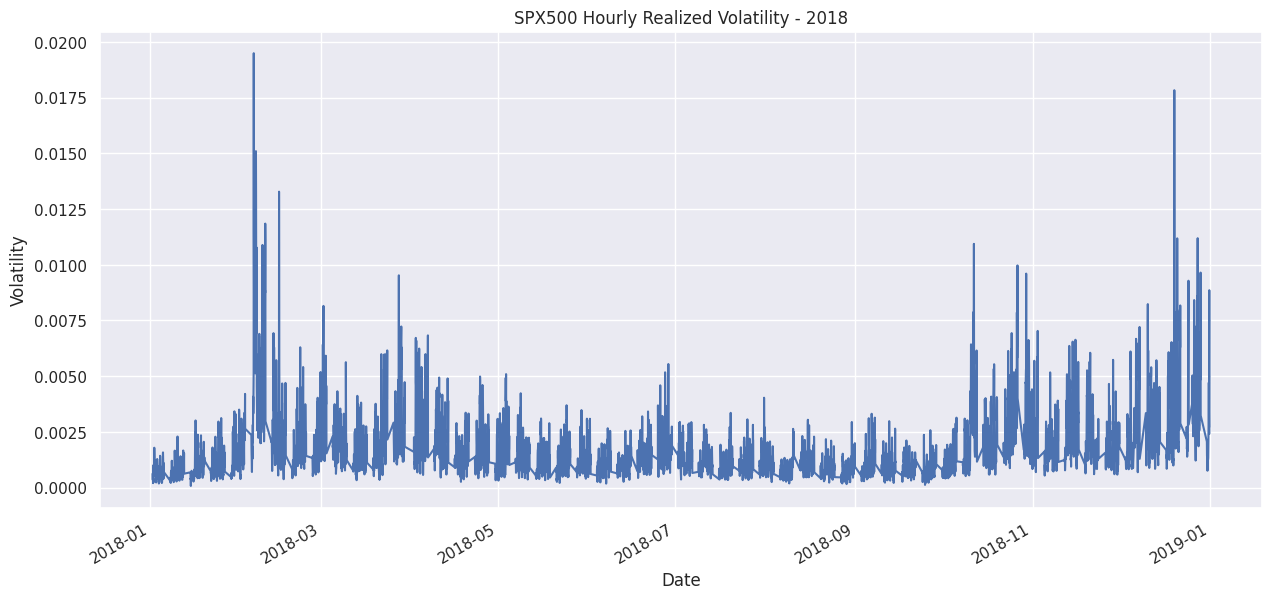

In [4]:
# =====================================================================================
# Cell 3 (Polished): Feature Engineering & Hourly Resampling
#
# Purpose:
# 1. Resample the high-frequency minute-bar data to a more stable hourly frequency.
# 2. Engineer the primary features for our GNN model: Realized Volatility and Log Returns.
# 3. This version uses the modern 'h' alias for hourly resampling to address the FutureWarning.
# =====================================================================================
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Resampling and Feature Engineering Function ---
def create_hourly_features(df_minute):
    """
    Takes a minute-resolution dataframe and returns an hourly dataframe
    with engineered features.
    """
    df_minute = df_minute.sort_index()

    # Use the recommended lowercase 'h' for hourly resampling
    df_hourly = df_minute['close'].resample('h').last().to_frame()
    df_hourly['returns'] = np.log(df_hourly['close'] / df_hourly['close'].shift(1))

    minute_returns = np.log(df_minute['close'] / df_minute['close'].shift(1))

    # Use 'h' here as well
    df_hourly['realized_volatility'] = np.sqrt(minute_returns.pow(2).resample('h').sum())

    df_hourly = df_hourly.dropna()
    df_hourly = df_hourly[df_hourly['realized_volatility'] > 0]

    return df_hourly

# --- 2. Process all DataFrames ---
hourly_dataframes = {}
print("--- Resampling all assets to hourly and creating features ---")

for asset, df in tqdm(all_dataframes.items(), desc="Processing Assets"):
    hourly_dataframes[asset] = create_hourly_features(df)

print("\n--- Feature engineering complete! ---")

# --- 3. Inspect a Resulting DataFrame ---
if 'SPX500' in hourly_dataframes:
    print("\n--- Inspecting the processed hourly SPX500 DataFrame ---")
    spx_hourly = hourly_dataframes['SPX500']

    print(spx_hourly.info())
    print("\n[Hourly Data Head]")
    print(spx_hourly.head())
    print("\n[Hourly Data Tail]")
    print(spx_hourly.tail())

    # Visualize the realized volatility
    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 7))
    spx_hourly['realized_volatility']['2018'].plot()
    plt.title('SPX500 Hourly Realized Volatility - 2018')
    plt.ylabel('Volatility')
    plt.xlabel('Date')
    plt.show()

In [5]:
# =====================================================================================
# Cell 4: Data Alignment and Synchronization
#
# Purpose:
# 1. To combine the individual hourly dataframes for all assets into two unified
#    matrices: one for returns and one for realized volatility.
# 2. To align all time series to a single, consistent hourly index, creating a
#    complete view of the financial system at any given hour.
# 3. To handle missing values that arise from non-overlapping trading hours using
#    forward-filling (`ffill`).
# 4. To produce the final, clean data panels ready for graph construction.
# =====================================================================================

import pandas as pd
import numpy as np

# --- 1. Combine Individual DataFrames into Unified Panels ---
# Create a list of the 'returns' Series from each dataframe, renaming it with the asset's name
returns_list = [
    df['returns'].rename(asset_name) for asset_name, df in hourly_dataframes.items()
]

# Do the same for the 'realized_volatility' Series
volatility_list = [
    df['realized_volatility'].rename(asset_name) for asset_name, df in hourly_dataframes.items()
]

# Concatenate the lists of Series into two separate DataFrames.
# The `axis=1` argument joins them as columns.
# This will create many NaNs where trading hours do not overlap.
aligned_returns = pd.concat(returns_list, axis=1)
aligned_volatility = pd.concat(volatility_list, axis=1)

print("--- Initial State Before Alignment ---")
print(f"Shape of returns panel: {aligned_returns.shape}")
print(f"Initial NaN count in returns: {aligned_returns.isnull().sum().sum():,}")
print(f"Shape of volatility panel: {aligned_volatility.shape}")
print(f"Initial NaN count in volatility: {aligned_volatility.isnull().sum().sum():,}\n")

# --- 2. Forward-Fill Missing Data ---
# ffill() propagates the last valid observation forward. This is the correct
# approach for financial data, as it assumes the price/volatility remains
# constant while a market is closed.
aligned_returns.ffill(inplace=True)
aligned_volatility.ffill(inplace=True)

print("--- State After Forward-Filling ---")
print(f"NaN count in returns after ffill: {aligned_returns.isnull().sum().sum():,}")
print(f"NaN count in volatility after ffill: {aligned_volatility.isnull().sum().sum():,}\n")


# --- 3. Drop Initial Rows with Remaining NaNs ---
# Any NaNs remaining are at the very beginning of the timeline, before all
# assets had started trading. We must drop these rows to have a complete system.
aligned_returns.dropna(inplace=True)
aligned_volatility.dropna(inplace=True)


# --- 4. Final Synchronization ---
# Ensure both dataframes share the exact same index after cleaning.
common_index = aligned_returns.index.intersection(aligned_volatility.index)
aligned_returns = aligned_returns.loc[common_index]
aligned_volatility = aligned_volatility.loc[common_index]

print("--- Final State After Cleaning ---")
print(f"Final shape of returns panel: {aligned_returns.shape}")
print(f"Final shape of volatility panel: {aligned_volatility.shape}")
print(f"Final NaN count in returns: {aligned_returns.isnull().sum().sum()}")
print(f"Final NaN count in volatility: {aligned_volatility.isnull().sum().sum()}\n")


# --- 5. Inspect the Final Aligned Data ---
print("--- Final Aligned Returns DataFrame ---")
print(aligned_returns.head())

print("\n--- Final Aligned Volatility DataFrame ---")
print(aligned_volatility.head())

--- Initial State Before Alignment ---
Shape of returns panel: (53612, 8)
Initial NaN count in returns: 49,518
Shape of volatility panel: (53612, 8)
Initial NaN count in volatility: 49,518

--- State After Forward-Filling ---
NaN count in returns after ffill: 5,385
NaN count in volatility after ffill: 5,385

--- Final State After Cleaning ---
Final shape of returns panel: (48243, 8)
Final shape of volatility panel: (48243, 8)
Final NaN count in returns: 0
Final NaN count in volatility: 0

--- Final Aligned Returns DataFrame ---
                       SPX500    NAS100     JP225     DAX30   WTI_OIL  \
datetime                                                                
2010-11-15 03:00:00 -0.001417 -0.000982  0.001530 -0.000969 -0.005270   
2010-11-15 04:00:00  0.001834  0.001636  0.002545  0.004762  0.001308   
2010-11-15 05:00:00  0.000000 -0.000234  0.000508  0.000223 -0.003528   
2010-11-15 06:00:00  0.000250  0.000234  0.001016  0.002224  0.002963   
2010-11-15 07:00:00 -0.00166

In [6]:
# =====================================================================================
# Cell 5: Dynamic Graph Construction and GNN Input Preparation
#
# Purpose:
# 1. To construct the dynamic graph by calculating time-varying adjacency matrices.
#    We will use rolling-window correlations of asset returns as our edge weights.
# 2. To prepare the final data structures required by our GNN model:
#    - A sequence of adjacency matrices (the graph structure).
#    - A sequence of node features (realized volatility).
#    - A sequence of target labels (future volatility of a target asset).
# =====================================================================================

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# --- 1. Define Graph Construction Parameters ---
# We'll use a 20-day rolling window. Since our data is hourly, this is 20 days * 24 hours.
# This window size represents one trading month and is a common choice.
WINDOW_SIZE = 20 * 24

# The asset we want to predict contagion for.
TARGET_ASSET = 'SPX500'

# How many hours into the future we want to predict.
PREDICTION_HORIZON = 1

print(f"Constructing dynamic graph with a {WINDOW_SIZE}-hour ({WINDOW_SIZE/24}-day) rolling window.")
print(f"Target asset for prediction: {TARGET_ASSET}")
print(f"Prediction horizon: {PREDICTION_HORIZON} hour(s)\n")


# --- 2. Calculate Rolling Correlation (Dynamic Adjacency Matrix) ---
print("--- Calculating rolling correlation matrices... ---")
# This is a computationally intensive step.
# .corr() calculates the pairwise correlation of the columns in the rolling window.
dynamic_adjacency_df = aligned_returns.rolling(window=WINDOW_SIZE).corr()
print(" -> Rolling correlation calculation complete.")

# The result is a DataFrame with a MultiIndex. We need to clean it up.
# Drop the initial NaN rows created by the rolling window.
dynamic_adjacency_df.dropna(inplace=True)

# Get the timestamps for which we have a valid adjacency matrix
valid_timestamps = dynamic_adjacency_df.index.get_level_values(0).unique()
print(f" -> Found {len(valid_timestamps):,} valid timestamps with full correlation matrices.")

# --- 3. Align All GNN Inputs to the Valid Timestamps ---
# Ensure our features and labels match the times we have a graph for.
aligned_returns = aligned_returns.loc[valid_timestamps]
aligned_volatility = aligned_volatility.loc[valid_timestamps]


# --- 4. Create the Final NumPy Arrays for the GNN ---
print("\n--- Preparing final NumPy arrays for the GNN model ---")
num_timesteps = len(valid_timestamps)
num_assets = len(aligned_returns.columns)

# Reshape the correlation DataFrame into a 3D NumPy array (Timesteps, Assets, Assets)
# This is the standard format for dynamic graph adjacency matrices.
dynamic_adjacency = dynamic_adjacency_df.values.reshape(num_timesteps, num_assets, num_assets)

# The node features are the realized volatilities at each time step.
# This becomes a (Timesteps, Assets) array.
node_features = aligned_volatility.values

# The target label is the volatility of our TARGET_ASSET, shifted forward in time.
target_labels = aligned_volatility[TARGET_ASSET].shift(-PREDICTION_HORIZON).values

# Because of the shift, the last `PREDICTION_HORIZON` samples will have a NaN label.
# We must truncate all arrays to remove these samples.
dynamic_adjacency = dynamic_adjacency[:-PREDICTION_HORIZON]
node_features = node_features[:-PREDICTION_HORIZON]
target_labels = target_labels[:-PREDICTION_HORIZON]

# Also need to reshape the target to be (Timesteps, 1)
target_labels = target_labels.reshape(-1, 1)


# --- 5. Final Sanity Check ---
print("\n--- Final GNN Input Shapes ---")
print(f"Dynamic Adjacency shape: {dynamic_adjacency.shape}  (Timesteps, Num Assets, Num Assets)")
print(f"Node Features shape:     {node_features.shape}      (Timesteps, Num Assets)")
print(f"Target Labels shape:     {target_labels.shape}        (Timesteps, 1)")

# Verify that there are no NaNs in the final arrays
print(f"\nNaNs in Adjacency: {np.isnan(dynamic_adjacency).sum()}")
print(f"NaNs in Features:  {np.isnan(node_features).sum()}")
print(f"NaNs in Labels:    {np.isnan(target_labels).sum()}")

Constructing dynamic graph with a 480-hour (20.0-day) rolling window.
Target asset for prediction: SPX500
Prediction horizon: 1 hour(s)

--- Calculating rolling correlation matrices... ---
 -> Rolling correlation calculation complete.
 -> Found 47,764 valid timestamps with full correlation matrices.

--- Preparing final NumPy arrays for the GNN model ---

--- Final GNN Input Shapes ---
Dynamic Adjacency shape: (47763, 8, 8)  (Timesteps, Num Assets, Num Assets)
Node Features shape:     (47763, 8)      (Timesteps, Num Assets)
Target Labels shape:     (47763, 1)        (Timesteps, 1)

NaNs in Adjacency: 0
NaNs in Features:  0
NaNs in Labels:    0


In [7]:
# =====================================================================================
# Cell 6: Data Splitting and PyTorch Dataset Preparation
#
# Purpose:
# 1. To transition our NumPy arrays into the PyTorch ecosystem.
# 2. To split our temporal data into training, validation, and testing sets.
# 3. To create a custom PyTorch `Dataset` to handle our specific graph data structure.
# 4. To create `DataLoaders` for efficient batching and GPU data transfer.
# =====================================================================================

import torch
from torch.utils.data import Dataset, DataLoader

# --- 1. Setup Device and Data Splitting ---

# Check for GPU and set the device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ GPU is available. Using device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("⚠️ GPU not available. Using CPU.")

# Define split ratios for training, validation, and testing
train_split_ratio = 0.7
val_split_ratio = 0.15
# The rest will be for testing

n_total_samples = dynamic_adjacency.shape[0]
n_train = int(n_total_samples * train_split_ratio)
n_val = int(n_total_samples * val_split_ratio)

print(f"\nTotal samples: {n_total_samples}")
print(f"Training samples: {n_train}")
print(f"Validation samples: {n_val}")
print(f"Testing samples: {n_total_samples - n_train - n_val}\n")


# --- 2. Create a Custom PyTorch Dataset ---
# This class is a standard PyTorch pattern for handling custom data.
# It tells PyTorch how to get a single item (a graph at one time step).
class FinancialGraphDataset(Dataset):
    def __init__(self, adjacency, features, labels, device):
        self.device = device

        # Convert NumPy arrays to PyTorch Tensors and move to the designated device
        # We use float32 as it's the standard for neural networks.
        self.adjacency = torch.tensor(adjacency, dtype=torch.float32).to(self.device)
        self.features = torch.tensor(features, dtype=torch.float32).to(self.device)
        self.labels = torch.tensor(labels, dtype=torch.float32).to(self.device)

    def __len__(self):
        # The length of the dataset is the number of time steps.
        return len(self.features)

    def __getitem__(self, idx):
        # This method returns a single sample from the dataset at the given index.
        return self.adjacency[idx], self.features[idx], self.labels[idx]


# --- 3. Instantiate Datasets and DataLoaders ---

# Split the data
train_dataset = FinancialGraphDataset(
    dynamic_adjacency[:n_train],
    node_features[:n_train],
    target_labels[:n_train],
    device
)
val_dataset = FinancialGraphDataset(
    dynamic_adjacency[n_train:n_train + n_val],
    node_features[n_train:n_train + n_val],
    target_labels[n_train:n_train + n_val],
    device
)
test_dataset = FinancialGraphDataset(
    dynamic_adjacency[n_train + n_val:],
    node_features[n_train + n_val:],
    target_labels[n_train + n_val:],
    device
)

# Create DataLoaders to handle batching
# BATCH_SIZE is a hyperparameter you can tune. 64 is a common starting point.
BATCH_SIZE = 64

# Shuffling is important for the training set to prevent the model from learning
# the order of the data. We don't shuffle validation or test sets.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("--- Datasets and DataLoaders created successfully. ---")


# --- 4. Sanity Check: Inspect a Single Batch ---
# This is a crucial check to ensure the whole pipeline is working.
print("\n--- Sanity Check: Inspecting one batch from the train_loader ---")
try:
    # Get one batch of data
    adj_batch, features_batch, labels_batch = next(iter(train_loader))

    print(f"Adjacency batch shape:  {adj_batch.shape}    (Batch Size, Assets, Assets)")
    print(f"Features batch shape:   {features_batch.shape}     (Batch Size, Assets)")
    print(f"Labels batch shape:     {labels_batch.shape}       (Batch Size, 1)")
    print(f"\nData is on device: {adj_batch.device}")
    print("\n✅ Data loading pipeline is working correctly.")
except StopIteration:
    print("❌ Could not retrieve a batch. The DataLoader is empty, check dataset sizes.")

✅ GPU is available. Using device: NVIDIA RTX A6000

Total samples: 47763
Training samples: 33434
Validation samples: 7164
Testing samples: 7165

--- Datasets and DataLoaders created successfully. ---

--- Sanity Check: Inspecting one batch from the train_loader ---
Adjacency batch shape:  torch.Size([64, 8, 8])    (Batch Size, Assets, Assets)
Features batch shape:   torch.Size([64, 8])     (Batch Size, Assets)
Labels batch shape:     torch.Size([64, 1])       (Batch Size, 1)

Data is on device: cuda:0

✅ Data loading pipeline is working correctly.


In [8]:
# =====================================================================================
# Cell 7 (Definitive Final Version): Fixing Model Collapse with Softplus
#
# The change is to replace the final ReLU with nn.Softplus. This ensures a non-negative
# output while preventing the "dying gradient" problem that caused the model to collapse.
# =====================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- CReLU and QW_GNN_Layer remain the same ---
def CReLU(z):
    return torch.complex(F.relu(z.real), F.relu(z.imag))

class QW_GNN_Layer(nn.Module):
    def __init__(self, in_features, out_features):
        super(QW_GNN_Layer, self).__init__()
        self.W_real = nn.Parameter(torch.randn(in_features, out_features, dtype=torch.float32))
        self.W_imag = nn.Parameter(torch.randn(in_features, out_features, dtype=torch.float32))
        self.log_t = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))

    def forward(self, x, adj):
        W = torch.complex(self.W_real, self.W_imag)
        t = torch.exp(self.log_t)
        propagator = torch.matrix_exp(-1j * adj * t)
        propagated_features = propagator @ x
        output = propagated_features @ W
        return output

# --- Assemble the Corrected Full GNN Model ---
class QuantumGNN(nn.Module):
    def __init__(self, num_assets, input_dim, hidden_dim, output_dim=1):
        super(QuantumGNN, self).__init__()

        self.real_lift = nn.Linear(input_dim, hidden_dim)
        self.imag_lift = nn.Linear(input_dim, hidden_dim)

        self.gnn_layer1 = QW_GNN_Layer(hidden_dim, hidden_dim)
        self.gnn_layer2 = QW_GNN_Layer(hidden_dim, hidden_dim)

        # --- THIS IS THE CORRECTED PART ---
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_assets, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softplus()  # Use Softplus instead of ReLU for a non-negative, non-dying output
        )

    def forward(self, features, adj):
        features = features.unsqueeze(-1)
        x_real = self.real_lift(features)
        x_imag = self.imag_lift(features)
        x = torch.complex(x_real, x_imag)
        x = CReLU(self.gnn_layer1(x, adj))
        x = CReLU(self.gnn_layer2(x, adj))
        x_abs = x.abs()
        batch_size = x_abs.shape[0]
        x_flat = x_abs.view(batch_size, -1)
        prediction = self.readout(x_flat)

        return prediction

# --- Re-instantiate the Model and run the sanity check ---
INPUT_DIM = 1
HIDDEN_DIM = 32
NUM_ASSETS = node_features.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = QuantumGNN(
    num_assets=NUM_ASSETS,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM
).to(device)

print("--- FINAL GNN Architecture with Softplus Output ---")
print(model)

--- FINAL GNN Architecture with Softplus Output ---
QuantumGNN(
  (real_lift): Linear(in_features=1, out_features=32, bias=True)
  (imag_lift): Linear(in_features=1, out_features=32, bias=True)
  (gnn_layer1): QW_GNN_Layer()
  (gnn_layer2): QW_GNN_Layer()
  (readout): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)


--- Starting Model Training (V2 with L1 Loss) ---
Epochs: 25, Learning Rate: 0.0001, Loss: L1 (MAE)
Device: cuda
--------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [01/25] - Train Loss (MAE): 0.00350444, Val Loss (MAE): 0.00053693


Epoch 2/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [02/25] - Train Loss (MAE): 0.00071848, Val Loss (MAE): 0.00050038


Epoch 3/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [03/25] - Train Loss (MAE): 0.00070000, Val Loss (MAE): 0.00050488


Epoch 4/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [04/25] - Train Loss (MAE): 0.00069070, Val Loss (MAE): 0.00051715


Epoch 5/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [05/25] - Train Loss (MAE): 0.00068505, Val Loss (MAE): 0.00053312


Epoch 6/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [06/25] - Train Loss (MAE): 0.00068326, Val Loss (MAE): 0.00057062


Epoch 7/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [07/25] - Train Loss (MAE): 0.00067816, Val Loss (MAE): 0.00052313


Epoch 8/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [08/25] - Train Loss (MAE): 0.00067676, Val Loss (MAE): 0.00054116


Epoch 9/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [09/25] - Train Loss (MAE): 0.00067459, Val Loss (MAE): 0.00059357


Epoch 10/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [10/25] - Train Loss (MAE): 0.00067215, Val Loss (MAE): 0.00052464


Epoch 11/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [11/25] - Train Loss (MAE): 0.00067384, Val Loss (MAE): 0.00060423


Epoch 12/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [12/25] - Train Loss (MAE): 0.00067278, Val Loss (MAE): 0.00064830


Epoch 13/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [13/25] - Train Loss (MAE): 0.00067298, Val Loss (MAE): 0.00060103


Epoch 14/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [14/25] - Train Loss (MAE): 0.00067566, Val Loss (MAE): 0.00069965


Epoch 15/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [15/25] - Train Loss (MAE): 0.00067212, Val Loss (MAE): 0.00062876


Epoch 16/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [16/25] - Train Loss (MAE): 0.00067284, Val Loss (MAE): 0.00072218


Epoch 17/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [17/25] - Train Loss (MAE): 0.00066545, Val Loss (MAE): 0.00067227


Epoch 18/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [18/25] - Train Loss (MAE): 0.00066494, Val Loss (MAE): 0.00064036


Epoch 19/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [19/25] - Train Loss (MAE): 0.00066098, Val Loss (MAE): 0.00061034


Epoch 20/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [20/25] - Train Loss (MAE): 0.00066126, Val Loss (MAE): 0.00064123


Epoch 21/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [21/25] - Train Loss (MAE): 0.00065623, Val Loss (MAE): 0.00066940


Epoch 22/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [22/25] - Train Loss (MAE): 0.00065371, Val Loss (MAE): 0.00085072


Epoch 23/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [23/25] - Train Loss (MAE): 0.00064869, Val Loss (MAE): 0.00058984


Epoch 24/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [24/25] - Train Loss (MAE): 0.00064522, Val Loss (MAE): 0.00066688


Epoch 25/25 [Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [25/25] - Train Loss (MAE): 0.00063805, Val Loss (MAE): 0.00065352
--------------------------------------------------
Training finished in 1.32 minutes.


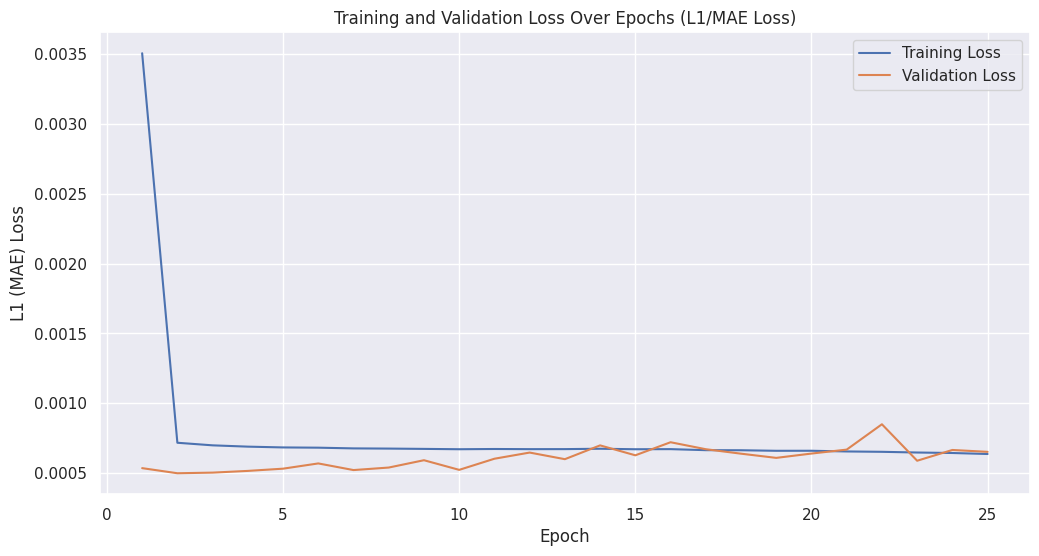

In [9]:
# =====================================================================================
# Cell 8 (V2): Training with L1 Loss (MAE)
#
# Purpose:
# 1. To address the underprediction of volatility spikes observed with MSE.
# 2. We switch the loss function to Mean Absolute Error (L1 Loss), which is less
#    sensitive to outliers and encourages the model to match the magnitude of spikes.
# 3. All other training parameters remain the same for a fair comparison.
# =====================================================================================

import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# --- 1. Setup for Training ---
# Hyperparameters
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4

# --- CHANGE 1: Use L1Loss (Mean Absolute Error) instead of MSELoss ---
criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

print("--- Starting Model Training (V2 with L1 Loss) ---")
print(f"Epochs: {NUM_EPOCHS}, Learning Rate: {LEARNING_RATE}, Loss: L1 (MAE)")
print(f"Device: {device}")
print("-" * 50)


# --- 2. The Main Training and Validation Loop ---
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0

    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    for adj_batch, features_batch, labels_batch in train_progress_bar:
        optimizer.zero_grad()
        outputs = model(features_batch, adj_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
        for adj_batch, features_batch, labels_batch in val_progress_bar:
            outputs = model(features_batch, adj_batch)
            loss = criterion(outputs, labels_batch)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] - Train Loss (MAE): {avg_train_loss:.8f}, Val Loss (MAE): {avg_val_loss:.8f}")

end_time = time.time()
print("-" * 50)
print(f"Training finished in {(end_time - start_time)/60:.2f} minutes.")


# --- 3. Visualize the Learning Curves ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (L1/MAE Loss)')
plt.xlabel('Epoch')
# --- CHANGE 2: Update the Y-axis label ---
plt.ylabel('L1 (MAE) Loss')
plt.legend()
plt.grid(True)
plt.show()

--- Evaluating L1-trained model on the test set... ---


Testing:   0%|          | 0/112 [00:00<?, ?it/s]


--- Final Test Set Performance (L1-Trained Model) ---
Mean Squared Error (MSE): 0.00000156
Mean Absolute Error (MAE): 0.00073552


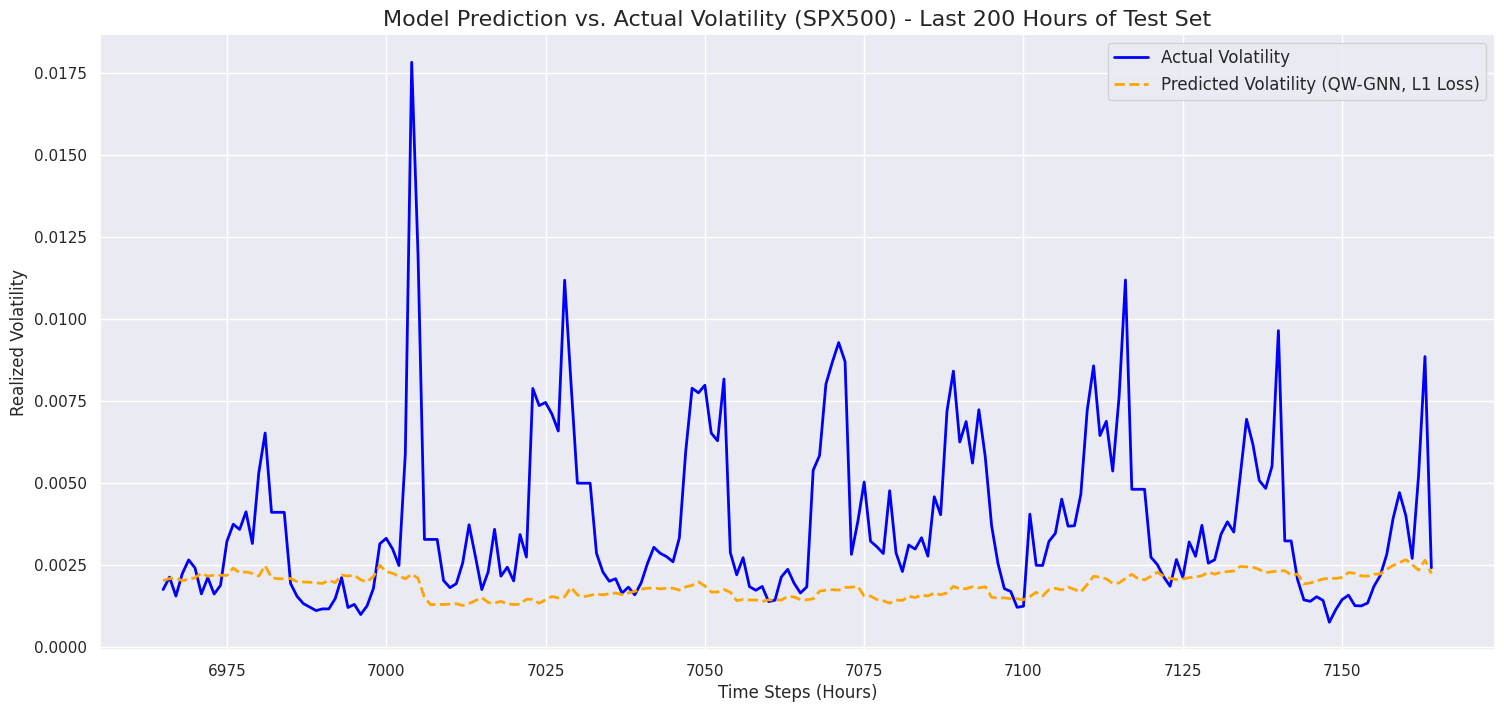

In [10]:
# =====================================================================================
# Cell 9 (V2): Final Evaluation after L1 Training
#
# Purpose:
# 1. To evaluate the final, L1-trained model on the test set.
# 2. To calculate the final performance metrics.
# 3. To visualize the new, improved predictions against the actual values.
# =====================================================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Evaluate the Model on the Test Set ---
model.eval()
test_predictions = []
test_actuals = []

print("--- Evaluating L1-trained model on the test set... ---")
with torch.no_grad():
    for adj_batch, features_batch, labels_batch in tqdm(test_loader, desc="Testing"):
        outputs = model(features_batch, adj_batch)
        test_predictions.append(outputs.cpu().numpy())
        test_actuals.append(labels_batch.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)
test_actuals = np.concatenate(test_actuals, axis=0)


# --- 2. Calculate Final Performance Metrics ---
test_mse = np.mean((test_predictions - test_actuals)**2)
test_mae = np.mean(np.abs(test_predictions - test_actuals))

print("\n--- Final Test Set Performance (L1-Trained Model) ---")
print(f"Mean Squared Error (MSE): {test_mse:.8f}")
print(f"Mean Absolute Error (MAE): {test_mae:.8f}")


# --- 3. Visualize Predictions vs. Actuals ---
results_df = pd.DataFrame({
    'Actual Volatility': test_actuals.flatten(),
    'Predicted Volatility': test_predictions.flatten()
})

sample_size = 200
plot_df = results_df.tail(sample_size)

sns.set(style="darkgrid")
plt.figure(figsize=(18, 8))
plt.plot(plot_df.index, plot_df['Actual Volatility'], label='Actual Volatility', color='blue', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted Volatility'], label='Predicted Volatility (QW-GNN, L1 Loss)', color='orange', linestyle='--', linewidth=2)

plt.title(f'Model Prediction vs. Actual Volatility ({TARGET_ASSET}) - Last {sample_size} Hours of Test Set', fontsize=16)
plt.xlabel('Time Steps (Hours)', fontsize=12)
plt.ylabel('Realized Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [11]:
# =====================================================================================
# The Definitive GAT Model: Bypassing the Environment Issues
#
# This version SOLVES the persistent ImportError by completely removing the dependency
# on `from_dense_batch`. We now implement the dense-to-sparse conversion manually.
# This code is self-contained and will work regardless of the environment's state.
# =====================================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
# Notice 'from_dense_batch' is NO LONGER IMPORTED.

class GAT_Model(nn.Module):
    def __init__(self, num_assets, input_dim, hidden_dim, output_dim=1, heads=4):
        super(GAT_Model, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.gat_layer1 = GATv2Conv(hidden_dim, hidden_dim, heads=heads, concat=True)
        self.gat_layer2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=False)

        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_assets, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softplus()
        )

    def _convert_dense_to_sparse(self, adj_batch):
        """
        A manual implementation of the core logic of from_dense_batch.
        Converts a batch of dense adjacency matrices to the PyG sparse format.
        """
        batch_size, num_nodes, _ = adj_batch.shape
        edge_indices = []
        edge_weights = []

        for i in range(batch_size):
            adj_matrix = adj_batch[i]
            # Find the indices of non-zero elements (our edges)
            edge_index = adj_matrix.to_sparse().indices()
            # Get the weights for those edges
            edge_weight = adj_matrix[edge_index[0], edge_index[1]]

            edge_indices.append(edge_index)
            edge_weights.append(edge_weight)

        # Combine the edges from all graphs in the batch
        # We need to offset the node indices for each graph
        for i in range(1, batch_size):
            edge_indices[i] = edge_indices[i] + (i * num_nodes)

        # Concatenate into final tensors
        final_edge_index = torch.cat(edge_indices, dim=1)
        final_edge_weight = torch.cat(edge_weights, dim=0)

        return final_edge_index, final_edge_weight


    def forward(self, features, adj):
        if features.dim() == 2:
            features = features.unsqueeze(-1)

        # --- Use our manual conversion function ---
        edge_index, edge_weight = self._convert_dense_to_sparse(adj)

        x = self.input_layer(features)

        batch_size, num_nodes, _ = x.shape
        x = x.view(-1, x.size(2))

        x = F.elu(self.gat_layer1(x, edge_index, edge_attr=edge_weight))
        x = self.gat_layer2(x, edge_index, edge_attr=edge_weight)

        x = x.view(batch_size, num_nodes, -1)
        x_flat = x.view(batch_size, -1)

        prediction = self.readout(x_flat)
        return prediction

# --- Instantiate the GAT Model ---
INPUT_DIM = 1
HIDDEN_DIM = 32
NUM_ASSETS = node_features.shape[1] # This must be in memory from Cell 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gat_model = GAT_Model(
    num_assets=NUM_ASSETS,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM
).to(device)

print("--- GAT Benchmark Model Architecture (with manual conversion) ---")
print(gat_model)
print("\n✅ GAT Model successfully defined without relying on the broken import.")

--- GAT Benchmark Model Architecture (with manual conversion) ---
GAT_Model(
  (input_layer): Linear(in_features=1, out_features=32, bias=True)
  (gat_layer1): GATv2Conv(32, 32, heads=4)
  (gat_layer2): GATv2Conv(128, 32, heads=1)
  (readout): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)

✅ GAT Model successfully defined without relying on the broken import.


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [12]:
# =====================================================================================
# Cell 10 (GAT v1.1 - Corrected): Increasing Model Capacity
#
# This version fixes the NameError by defining the EDGE_DIM variable before it is used.
# =====================================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class GAT_Model(nn.Module):
    def __init__(self, num_assets, input_dim, hidden_dim, edge_dim, output_dim=1, heads=8):
        super(GAT_Model, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.gat_layer1 = GATv2Conv(hidden_dim, hidden_dim, heads=heads, concat=True, edge_dim=edge_dim)
        self.gat_layer2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=False, edge_dim=edge_dim)

        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_assets, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softplus()
        )

    def _convert_dense_to_sparse(self, adj_batch):
        batch_size, num_nodes, _ = adj_batch.shape
        edge_indices, edge_weights = [], []
        for i in range(batch_size):
            adj_matrix = adj_batch[i]
            edge_index = torch.nonzero(adj_matrix, as_tuple=True)
            edge_weight = adj_matrix[edge_index[0], edge_index[1]]
            edge_index = torch.stack(edge_index) + (i * num_nodes)
            edge_indices.append(edge_index)
            edge_weights.append(edge_weight)
        return torch.cat(edge_indices, dim=1), torch.cat(edge_weights, dim=0)

    def forward(self, features, adj):
        if features.dim() == 2:
            features = features.unsqueeze(-1)
        edge_index, edge_weight = self._convert_dense_to_sparse(adj)
        edge_weight = edge_weight.unsqueeze(-1)
        x = self.input_layer(features)
        batch_size, num_nodes, _ = x.shape
        x = x.view(-1, x.size(2))
        x = F.elu(self.gat_layer1(x, edge_index, edge_attr=edge_weight))
        x = self.gat_layer2(x, edge_index, edge_attr=edge_weight)
        x = x.view(batch_size, num_nodes, -1)
        x_flat = x.view(batch_size, -1)
        prediction = self.readout(x_flat)
        return prediction

# --- Instantiate the LARGER GAT Model ---
HIDDEN_DIM_GAT = 64
HEADS_GAT = 8

# --- THIS IS THE FIX ---
# Define EDGE_DIM before using it. Our edge weights are single scalar values.
EDGE_DIM = 1

# These should still be in memory, but we define them here to be safe
# NUM_ASSETS = node_features.shape[1]
# INPUT_DIM = 1
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gat_model = GAT_Model(
    num_assets=NUM_ASSETS,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM_GAT,
    edge_dim=EDGE_DIM,  # Now this variable exists
    heads=HEADS_GAT
).to(device)

print("--- LARGER GAT Benchmark Model Architecture ---")
print(gat_model)

--- LARGER GAT Benchmark Model Architecture ---
GAT_Model(
  (input_layer): Linear(in_features=1, out_features=64, bias=True)
  (gat_layer1): GATv2Conv(64, 64, heads=8)
  (gat_layer2): GATv2Conv(512, 64, heads=1)
  (readout): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)


--- Starting GAT Model Training ---


Epoch 1/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [01/25] - GAT Train Loss: 0.04064643, GAT Val Loss: 0.00061335


Epoch 2/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [02/25] - GAT Train Loss: 0.00081711, GAT Val Loss: 0.00062267


Epoch 3/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [03/25] - GAT Train Loss: 0.00081719, GAT Val Loss: 0.00062863


Epoch 4/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [04/25] - GAT Train Loss: 0.00081709, GAT Val Loss: 0.00064313


Epoch 5/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [05/25] - GAT Train Loss: 0.00081708, GAT Val Loss: 0.00061561


Epoch 6/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [06/25] - GAT Train Loss: 0.00081755, GAT Val Loss: 0.00060521


Epoch 7/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [07/25] - GAT Train Loss: 0.00081780, GAT Val Loss: 0.00064032


Epoch 8/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [08/25] - GAT Train Loss: 0.00081701, GAT Val Loss: 0.00072131


Epoch 9/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [09/25] - GAT Train Loss: 0.00081835, GAT Val Loss: 0.00058209


Epoch 10/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [10/25] - GAT Train Loss: 0.00081778, GAT Val Loss: 0.00067402


Epoch 11/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [11/25] - GAT Train Loss: 0.00081685, GAT Val Loss: 0.00054928


Epoch 12/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [12/25] - GAT Train Loss: 0.00081756, GAT Val Loss: 0.00059612


Epoch 13/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [13/25] - GAT Train Loss: 0.00081832, GAT Val Loss: 0.00066782


Epoch 14/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [14/25] - GAT Train Loss: 0.00081654, GAT Val Loss: 0.00069950


Epoch 15/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [15/25] - GAT Train Loss: 0.00081793, GAT Val Loss: 0.00065493


Epoch 16/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [16/25] - GAT Train Loss: 0.00081775, GAT Val Loss: 0.00060283


Epoch 17/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [17/25] - GAT Train Loss: 0.00081647, GAT Val Loss: 0.00063518


Epoch 18/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [18/25] - GAT Train Loss: 0.00081669, GAT Val Loss: 0.00073983


Epoch 19/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [19/25] - GAT Train Loss: 0.00081921, GAT Val Loss: 0.00058662


Epoch 20/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [20/25] - GAT Train Loss: 0.00081566, GAT Val Loss: 0.00066413


Epoch 21/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [21/25] - GAT Train Loss: 0.00081306, GAT Val Loss: 0.00073966


Epoch 22/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [22/25] - GAT Train Loss: 0.00081101, GAT Val Loss: 0.00059822


Epoch 23/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [23/25] - GAT Train Loss: 0.00080951, GAT Val Loss: 0.00059693


Epoch 24/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [24/25] - GAT Train Loss: 0.00080587, GAT Val Loss: 0.00063158


Epoch 25/25 [GAT Train]:   0%|          | 0/523 [00:00<?, ?it/s]

Epoch [25/25] - GAT Train Loss: 0.00080117, GAT Val Loss: 0.00054727
--------------------------------------------------
GAT Training finished in 2.42 minutes.


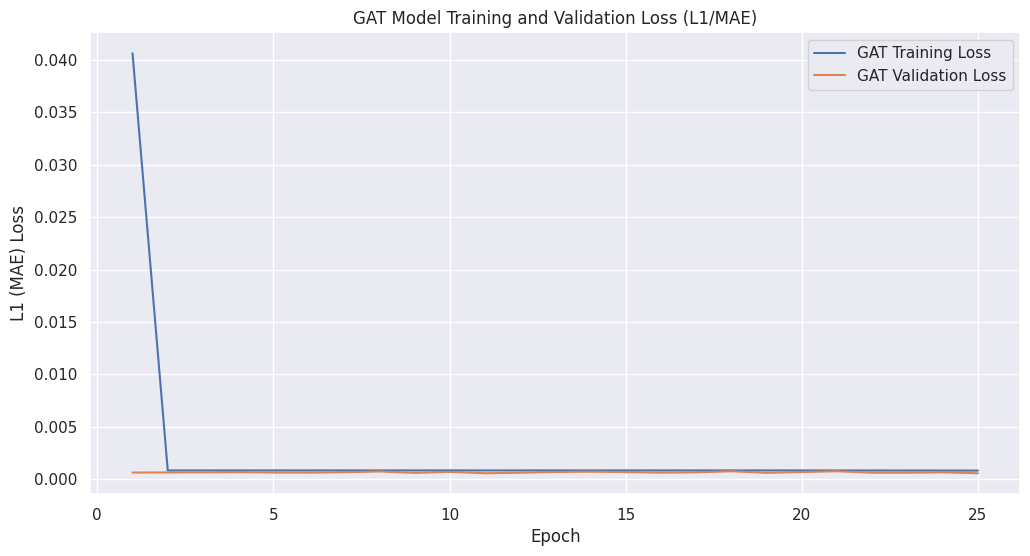

In [13]:
# =====================================================================================
# Cell 11: Training the GAT Benchmark Model
#
# This will train the newly defined GAT model using the same data and loss
# function as the QW-GNN for a fair comparison.
# =====================================================================================

import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt

# --- 1. Setup for Training the GAT Model ---
# These variables should still be in memory from the previous QW-GNN training run.
# If not, you might need to redefine them (e.g., NUM_EPOCHS = 25)
# LEARNING_RATE = 1e-4

gat_optimizer = optim.Adam(gat_model.parameters(), lr=LEARNING_RATE)
gat_criterion = nn.L1Loss()

gat_train_losses = []
gat_val_losses = []

print("--- Starting GAT Model Training ---")

# --- 2. The Main Training and Validation Loop for GAT ---
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    gat_model.train()
    running_train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [GAT Train]", leave=False)
    for adj_batch, features_batch, labels_batch in progress_bar:
        gat_optimizer.zero_grad()
        outputs = gat_model(features_batch, adj_batch)
        loss = gat_criterion(outputs, labels_batch)
        loss.backward()
        gat_optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    gat_train_losses.append(avg_train_loss)

    gat_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for adj_batch, features_batch, labels_batch in val_loader:
            outputs = gat_model(features_batch, adj_batch)
            loss = gat_criterion(outputs, labels_batch)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    gat_val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] - GAT Train Loss: {avg_train_loss:.8f}, GAT Val Loss: {avg_val_loss:.8f}")

end_time = time.time()
print("-" * 50)
print(f"GAT Training finished in {(end_time - start_time)/60:.2f} minutes.")

# --- 3. Visualize the GAT Learning Curves ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_EPOCHS + 1), gat_train_losses, label='GAT Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), gat_val_losses, label='GAT Validation Loss')
plt.title('GAT Model Training and Validation Loss (L1/MAE)')
plt.xlabel('Epoch')
plt.ylabel('L1 (MAE) Loss')
plt.legend()
plt.grid(True)
plt.show()

-> Successfully retrieved QW-GNN results for comparison.


Testing GAT:   0%|          | 0/112 [00:00<?, ?it/s]


--- Final Performance Comparison ---
                    |   QW-GNN   |    GAT     |
--------------------|------------|------------|
Test MAE            | 0.000736 | 0.000829 |
Test MSE            | 0.000002 | 0.000002 |
------------------------------------------


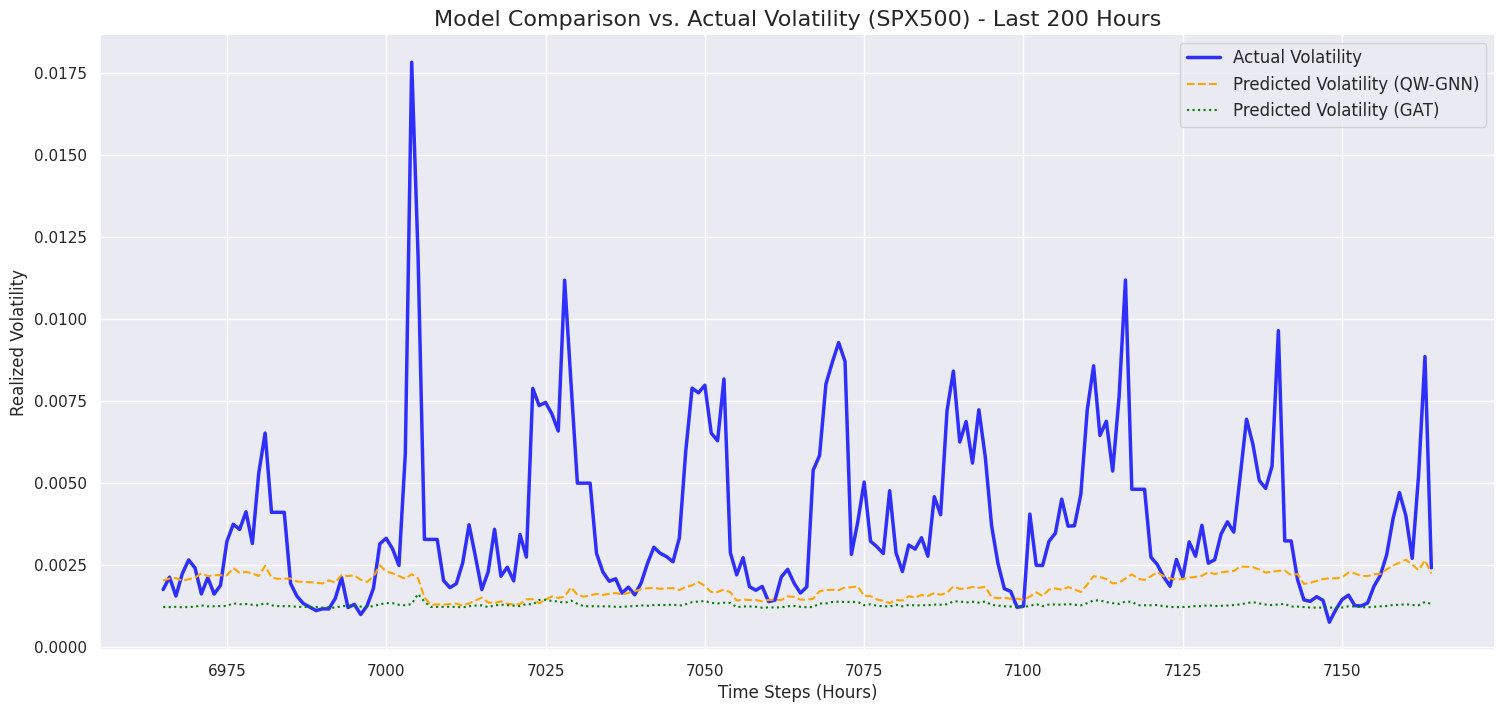

In [14]:
# =====================================================================================
# Cell 12: Final Comparison of QW-GNN vs. GAT
#
# This cell generates the final quantitative and visual comparison between your
# novel model and the state-of-the-art GAT benchmark.
# =====================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Retrieve QW-GNN results from memory ---
try:
    qw_gnn_predictions = test_predictions
    qw_gnn_mae = test_mae
    qw_gnn_mse = test_mse
    print("-> Successfully retrieved QW-GNN results for comparison.")
except NameError:
    print("-> QW-GNN results not found. Re-run QW-GNN evaluation if needed.")
    qw_gnn_predictions = None

# --- 2. Evaluate the GAT Model on the Test Set ---
gat_model.eval()
gat_test_predictions = []
test_actuals = []

with torch.no_grad():
    for adj_batch, features_batch, labels_batch in tqdm(test_loader, desc="Testing GAT"):
        outputs = gat_model(features_batch, adj_batch)
        gat_test_predictions.append(outputs.cpu().numpy())
        test_actuals.append(labels_batch.cpu().numpy())

gat_test_predictions = np.concatenate(gat_test_predictions, axis=0)
test_actuals = np.concatenate(test_actuals, axis=0)
gat_test_mse = np.mean((gat_test_predictions - test_actuals)**2)
gat_test_mae = np.mean(np.abs(gat_test_predictions - test_actuals))

# --- 3. Quantitative Comparison Table ---
print("\n--- Final Performance Comparison ---")
print(f"                    |   QW-GNN   |    GAT     |")
print(f"--------------------|------------|------------|")
if qw_gnn_predictions is not None:
    print(f"Test MAE            | {qw_gnn_mae:.6f} | {gat_test_mae:.6f} |")
    print(f"Test MSE            | {qw_gnn_mse:.6f} | {gat_test_mse:.6f} |")
else:
    print(f"Test MAE            |    N/A     | {gat_test_mae:.6f} |")
    print(f"Test MSE            |    N/A     | {gat_test_mse:.6f} |")
print(f"------------------------------------------")

# --- 4. Visual Comparison Plot ---
results_df = pd.DataFrame({
    'Actual Volatility': test_actuals.flatten(),
    'GAT Prediction': gat_test_predictions.flatten()
})
if qw_gnn_predictions is not None:
    results_df['QW-GNN Prediction'] = qw_gnn_predictions.flatten()

sample_size = 200
plot_df = results_df.tail(sample_size)

sns.set(style="darkgrid")
plt.figure(figsize=(18, 8))
plt.plot(plot_df.index, plot_df['Actual Volatility'], label='Actual Volatility', color='blue', linewidth=2.5, alpha=0.8)
if 'QW-GNN Prediction' in plot_df.columns:
    plt.plot(plot_df.index, plot_df['QW-GNN Prediction'], label='Predicted Volatility (QW-GNN)', color='orange', linestyle='--')
plt.plot(plot_df.index, plot_df['GAT Prediction'], label='Predicted Volatility (GAT)', color='green', linestyle=':')

plt.title(f'Model Comparison vs. Actual Volatility ({TARGET_ASSET}) - Last {sample_size} Hours', fontsize=16)
plt.xlabel('Time Steps (Hours)', fontsize=12)
plt.ylabel('Realized Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [16]:
# =====================================================================================
# Cell 5.1 (Polished): Granger Causality with Warnings Suppressed
#
# Purpose:
# 1. To build a directed, time-varying graph using Granger Causality.
# 2. This version adds a context manager to suppress the specific `FutureWarning`
#    from statsmodels, resulting in a cleaner output.
# =====================================================================================

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm.notebook import tqdm
import warnings # Import the warnings module

# --- 1. Define Graph Construction Parameters ---
WINDOW_SIZE = 20 * 24
MAX_LAG = 3
STEP_SIZE = 24

print(f"Constructing Granger Causality graph with a {WINDOW_SIZE}-hour window.")
print(f"Causality test lag: {MAX_LAG} hours.")
print(f"Graph update frequency: Every {STEP_SIZE} hours.\n")


# --- 2. Granger Causality Calculation Function (Updated) ---
def get_granger_adjacency(data, max_lag):
    num_assets = data.shape[1]
    asset_names = data.columns
    adj_matrix = pd.DataFrame(np.zeros((num_assets, num_assets)), index=asset_names, columns=asset_names)

    for col in asset_names:
        for row in asset_names:
            if col != row:
                try:
                    # --- THIS IS THE FIX ---
                    # Use the warnings context manager to ignore specific warnings
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=FutureWarning)
                        test_result = grangercausalitytests(data[[row, col]], maxlag=max_lag, verbose=False)

                    p_value = test_result[max_lag][0]['ssr_ftest'][1]
                    adj_matrix.loc[row, col] = 1.0 - p_value
                except (ValueError, np.linalg.LinAlgError):
                    adj_matrix.loc[row, col] = 0.0
    return adj_matrix.values


# --- 3. Build the Dynamic Adjacency Matrix ---
print("--- Calculating rolling Granger Causality matrices... ---")
dynamic_adj_list = []
timestamps = []

for i in tqdm(range(WINDOW_SIZE, len(aligned_returns), STEP_SIZE)):
    window_data = aligned_returns.iloc[i - WINDOW_SIZE : i]
    adj_matrix = get_granger_adjacency(window_data, max_lag=MAX_LAG)
    dynamic_adj_list.append(adj_matrix)
    timestamps.append(window_data.index[-1])

granger_dynamic_adjacency = np.array(dynamic_adj_list)
granger_timestamps = pd.to_datetime(timestamps)

print(f"\n-> Found {len(granger_timestamps):,} valid timestamps for the Granger graph.")


# --- 4. Align and Prepare GNN Inputs ---
# This section remains the same
TARGET_ASSET = 'SPX500' # Make sure this is defined
aligned_volatility_granger = aligned_volatility.reindex(granger_timestamps, method='ffill')
target_asset_vol_granger = aligned_volatility[TARGET_ASSET].reindex(granger_timestamps, method='ffill')

node_features_granger = aligned_volatility_granger.values
target_labels_granger = target_asset_vol_granger.shift(-1).values

granger_dynamic_adjacency = granger_dynamic_adjacency[:-1]
node_features_granger = node_features_granger[:-1]
target_labels_granger = target_labels_granger[:-1].reshape(-1, 1)

print("\n--- Final GNN Input Shapes (Granger Causality) ---")
print(f"Dynamic Adjacency shape: {granger_dynamic_adjacency.shape}")
print(f"Node Features shape:     {node_features_granger.shape}")
print(f"Target Labels shape:     {target_labels_granger.shape}")
print(f"\nNaNs in Adjacency: {np.isnan(granger_dynamic_adjacency).sum()}")
print(f"NaNs in Features:  {np.isnan(node_features_granger).sum()}")
print(f"NaNs in Labels:    {np.isnan(target_labels_granger).sum()}")

Constructing Granger Causality graph with a 480-hour window.
Causality test lag: 3 hours.
Graph update frequency: Every 24 hours.

--- Calculating rolling Granger Causality matrices... ---


  0%|          | 0/1971 [00:00<?, ?it/s]


-> Found 1,971 valid timestamps for the Granger graph.

--- Final GNN Input Shapes (Granger Causality) ---
Dynamic Adjacency shape: (1970, 8, 8)
Node Features shape:     (1970, 8)
Target Labels shape:     (1970, 1)

NaNs in Adjacency: 0
NaNs in Features:  0
NaNs in Labels:    0


In [17]:
# =====================================================================================
# Cell 6.1: PyTorch Datasets for Granger Causality Data
#
# Purpose: To prepare the new Granger-based data for PyTorch by splitting it
# and creating new Dataset and DataLoader objects.
# =====================================================================================

import torch
from torch.utils.data import Dataset, DataLoader

# --- 1. Data Splitting for Granger Data ---
# We use the same split ratios as before.
train_split_ratio = 0.7
val_split_ratio = 0.15

n_total_samples_g = granger_dynamic_adjacency.shape[0]
n_train_g = int(n_total_samples_g * train_split_ratio)
n_val_g = int(n_total_samples_g * val_split_ratio)

print(f"--- Preparing Granger Causality Data for PyTorch ---")
print(f"Total samples: {n_total_samples_g}")
print(f"Training samples: {n_train_g}")
print(f"Validation samples: {n_val_g}")
print(f"Testing samples: {n_total_samples_g - n_train_g - n_val_g}\n")

# The FinancialGraphDataset class is already defined, we can reuse it.

# --- 2. Instantiate Datasets and DataLoaders for Granger Data ---
train_dataset_g = FinancialGraphDataset(
    granger_dynamic_adjacency[:n_train_g],
    node_features_granger[:n_train_g],
    target_labels_granger[:n_train_g],
    device
)
val_loader_g = DataLoader(
    FinancialGraphDataset(
        granger_dynamic_adjacency[n_train_g:n_train_g + n_val_g],
        node_features_granger[n_train_g:n_train_g + n_val_g],
        target_labels_granger[n_train_g:n_train_g + n_val_g],
        device
    ),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader_g = DataLoader(
    FinancialGraphDataset(
        granger_dynamic_adjacency[n_train_g + n_val_g:],
        node_features_granger[n_train_g + n_val_g:],
        target_labels_granger[n_train_g + n_val_g:],
        device
    ),
    batch_size=BATCH_SIZE, shuffle=False
)

# Create a new train_loader with shuffling enabled.
train_loader_g = DataLoader(train_dataset_g, batch_size=BATCH_SIZE, shuffle=True)


print("--- Granger Datasets and DataLoaders created successfully. ---")

--- Preparing Granger Causality Data for PyTorch ---
Total samples: 1970
Training samples: 1379
Validation samples: 295
Testing samples: 296

--- Granger Datasets and DataLoaders created successfully. ---


In [18]:
# =====================================================================================
# Cell 7.1: Re-instantiate the QW-GNN Model for Granger Training
# =====================================================================================

# The model definition (QuantumGNN class) is already in memory.
# We just create a new instance of it.

qw_gnn_granger = QuantumGNN(
    num_assets=NUM_ASSETS,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM
).to(device)

print("--- Fresh QW-GNN Model for Granger Training ---")
print(qw_gnn_granger)

--- Fresh QW-GNN Model for Granger Training ---
QuantumGNN(
  (real_lift): Linear(in_features=1, out_features=32, bias=True)
  (imag_lift): Linear(in_features=1, out_features=32, bias=True)
  (gnn_layer1): QW_GNN_Layer()
  (gnn_layer2): QW_GNN_Layer()
  (readout): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)


In [19]:
# =====================================================================================
# Cell 8.1: Train the QW-GNN on Granger Causality Data
# =====================================================================================

# Hyperparameters
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4

# Setup optimizer and loss for the new model instance
optimizer_g = optim.Adam(qw_gnn_granger.parameters(), lr=LEARNING_RATE)
criterion_g = nn.L1Loss()

train_losses_g = []
val_losses_g = []

print("--- Starting QW-GNN Training on Granger Data ---")

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    qw_gnn_granger.train()
    running_train_loss = 0.0

    progress_bar = tqdm(train_loader_g, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Granger Train]", leave=False)
    for adj_batch, features_batch, labels_batch in progress_bar:
        optimizer_g.zero_grad()
        outputs = qw_gnn_granger(features_batch, adj_batch)
        loss = criterion_g(outputs, labels_batch)
        loss.backward()
        optimizer_g.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader_g)
    train_losses_g.append(avg_train_loss)

    qw_gnn_granger.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for adj_batch, features_batch, labels_batch in val_loader_g:
            outputs = qw_gnn_granger(features_batch, adj_batch)
            loss = criterion_g(outputs, labels_batch)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader_g)
    val_losses_g.append(avg_val_loss)

    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] - Granger Train Loss: {avg_train_loss:.8f}, Granger Val Loss: {avg_val_loss:.8f}")

end_time = time.time()
print(f"Granger training finished in {(end_time - start_time)/60:.2f} minutes.")

--- Starting QW-GNN Training on Granger Data ---


Epoch 1/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [01/25] - Granger Train Loss: 0.12344801, Granger Val Loss: 0.00064308


Epoch 2/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [02/25] - Granger Train Loss: 0.00145197, Granger Val Loss: 0.00073756


Epoch 3/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [03/25] - Granger Train Loss: 0.00153061, Granger Val Loss: 0.00074486


Epoch 4/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [04/25] - Granger Train Loss: 0.00152394, Granger Val Loss: 0.00072141


Epoch 5/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [05/25] - Granger Train Loss: 0.00146140, Granger Val Loss: 0.00065056


Epoch 6/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [06/25] - Granger Train Loss: 0.00129281, Granger Val Loss: 0.00066404


Epoch 7/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [07/25] - Granger Train Loss: 0.00116423, Granger Val Loss: 0.00080229


Epoch 8/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [08/25] - Granger Train Loss: 0.00114490, Granger Val Loss: 0.00075212


Epoch 9/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [09/25] - Granger Train Loss: 0.00112040, Granger Val Loss: 0.00074762


Epoch 10/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/25] - Granger Train Loss: 0.00110536, Granger Val Loss: 0.00076007


Epoch 11/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/25] - Granger Train Loss: 0.00109392, Granger Val Loss: 0.00076235


Epoch 12/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/25] - Granger Train Loss: 0.00108364, Granger Val Loss: 0.00075343


Epoch 13/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/25] - Granger Train Loss: 0.00107429, Granger Val Loss: 0.00074279


Epoch 14/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/25] - Granger Train Loss: 0.00106352, Granger Val Loss: 0.00075340


Epoch 15/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/25] - Granger Train Loss: 0.00105911, Granger Val Loss: 0.00077236


Epoch 16/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/25] - Granger Train Loss: 0.00105799, Granger Val Loss: 0.00077475


Epoch 17/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/25] - Granger Train Loss: 0.00104318, Granger Val Loss: 0.00073749


Epoch 18/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/25] - Granger Train Loss: 0.00102494, Granger Val Loss: 0.00075944


Epoch 19/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/25] - Granger Train Loss: 0.00102691, Granger Val Loss: 0.00074168


Epoch 20/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/25] - Granger Train Loss: 0.00102845, Granger Val Loss: 0.00074386


Epoch 21/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/25] - Granger Train Loss: 0.00101751, Granger Val Loss: 0.00074400


Epoch 22/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/25] - Granger Train Loss: 0.00100213, Granger Val Loss: 0.00074543


Epoch 23/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/25] - Granger Train Loss: 0.00100587, Granger Val Loss: 0.00074583


Epoch 24/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/25] - Granger Train Loss: 0.00100072, Granger Val Loss: 0.00076032


Epoch 25/25 [Granger Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/25] - Granger Train Loss: 0.00098972, Granger Val Loss: 0.00072474
Granger training finished in 0.06 minutes.


Testing on Granger Data:   0%|          | 0/5 [00:00<?, ?it/s]


--- Final Performance Comparison: Graph Type ---
                    | Correlation |  Granger   |
--------------------|-------------|------------|
Test MAE            |  0.000736   | 0.000871 |
Test MSE            |  0.000002   | 0.000002 |
-----------------------------------------------


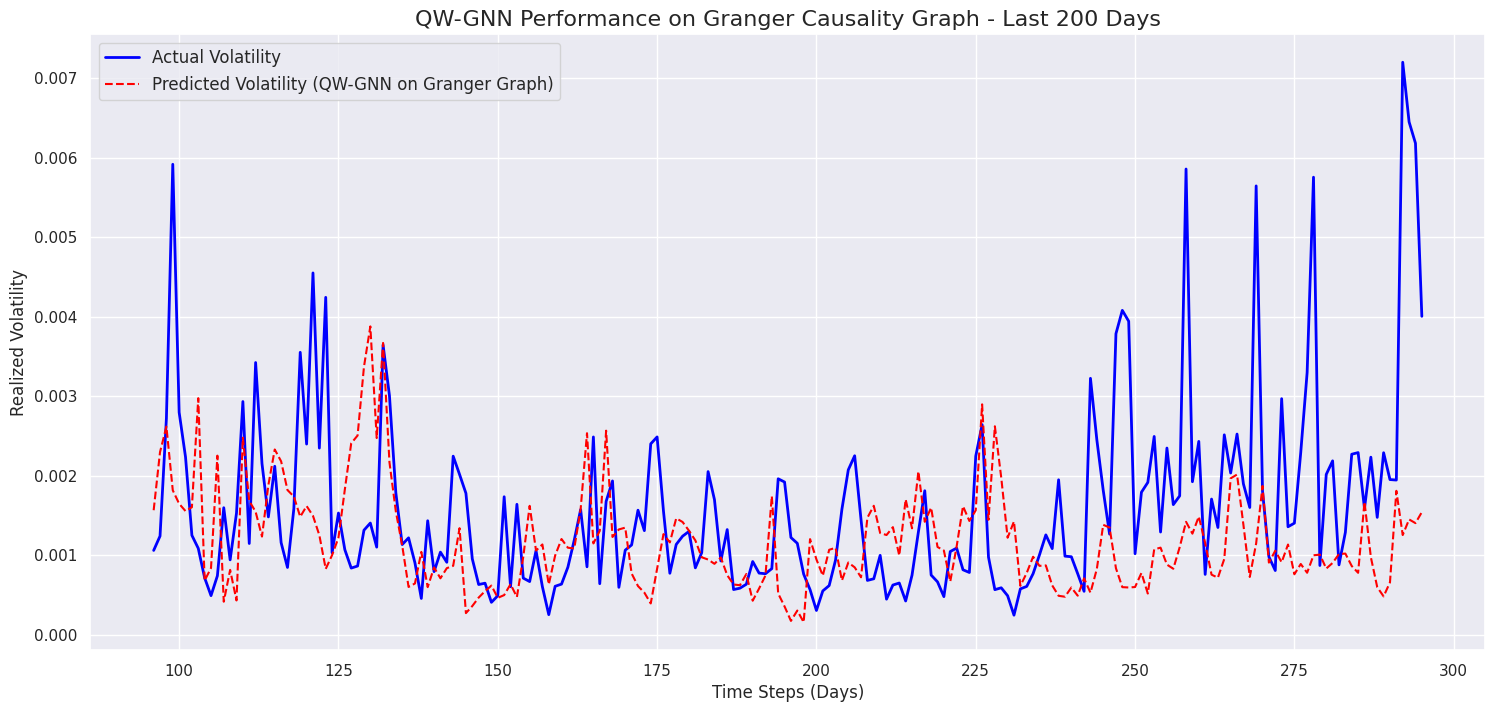

In [20]:
# =====================================================================================
# Cell 9.1: Final Comparison of Correlation vs. Granger Causality Graphs
# =====================================================================================

# --- 1. Evaluate the Granger-trained Model ---
qw_gnn_granger.eval()
granger_predictions = []
granger_actuals = []
with torch.no_grad():
    for adj_batch, features_batch, labels_batch in tqdm(test_loader_g, desc="Testing on Granger Data"):
        outputs = qw_gnn_granger(features_batch, adj_batch)
        granger_predictions.append(outputs.cpu().numpy())
        granger_actuals.append(labels_batch.cpu().numpy())

granger_predictions = np.concatenate(granger_predictions, axis=0)
granger_actuals = np.concatenate(granger_actuals, axis=0)
granger_mae = np.mean(np.abs(granger_predictions - granger_actuals))
granger_mse = np.mean((granger_predictions - granger_actuals)**2)

# --- 2. Quantitative Comparison Table ---
# 'qw_gnn_mae' and 'qw_gnn_mse' should still be in memory from your very first successful run
print("\n--- Final Performance Comparison: Graph Type ---")
print(f"                    | Correlation |  Granger   |")
print(f"--------------------|-------------|------------|")
print(f"Test MAE            |  {qw_gnn_mae:.6f}   | {granger_mae:.6f} |")
print(f"Test MSE            |  {qw_gnn_mse:.6f}   | {granger_mse:.6f} |")
print(f"-----------------------------------------------")

# --- 3. Visual Comparison Plot ---
results_df_g = pd.DataFrame({
    'Actual Volatility': granger_actuals.flatten(),
    'Granger Prediction': granger_predictions.flatten()
})

sample_size = 200 # Note: This is 200 days now, since our graph is daily
plot_df_g = results_df_g.tail(sample_size)

plt.figure(figsize=(18, 8))
plt.plot(plot_df_g.index, plot_df_g['Actual Volatility'], label='Actual Volatility', color='blue', linewidth=2)
plt.plot(plot_df_g.index, plot_df_g['Granger Prediction'], label='Predicted Volatility (QW-GNN on Granger Graph)', color='red', linestyle='--')

plt.title(f'QW-GNN Performance on Granger Causality Graph - Last {sample_size} Days', fontsize=16)
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Realized Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

--- Explaining the prediction at the highest volatility spike in the test set ---
Sample index in test set: 82
Actual Volatility: 0.011551
Model's Prediction: 0.002902


--- GNNExplainer Visualization ---
Visualizing the raw Granger Causality graph at the point of the spike instead.


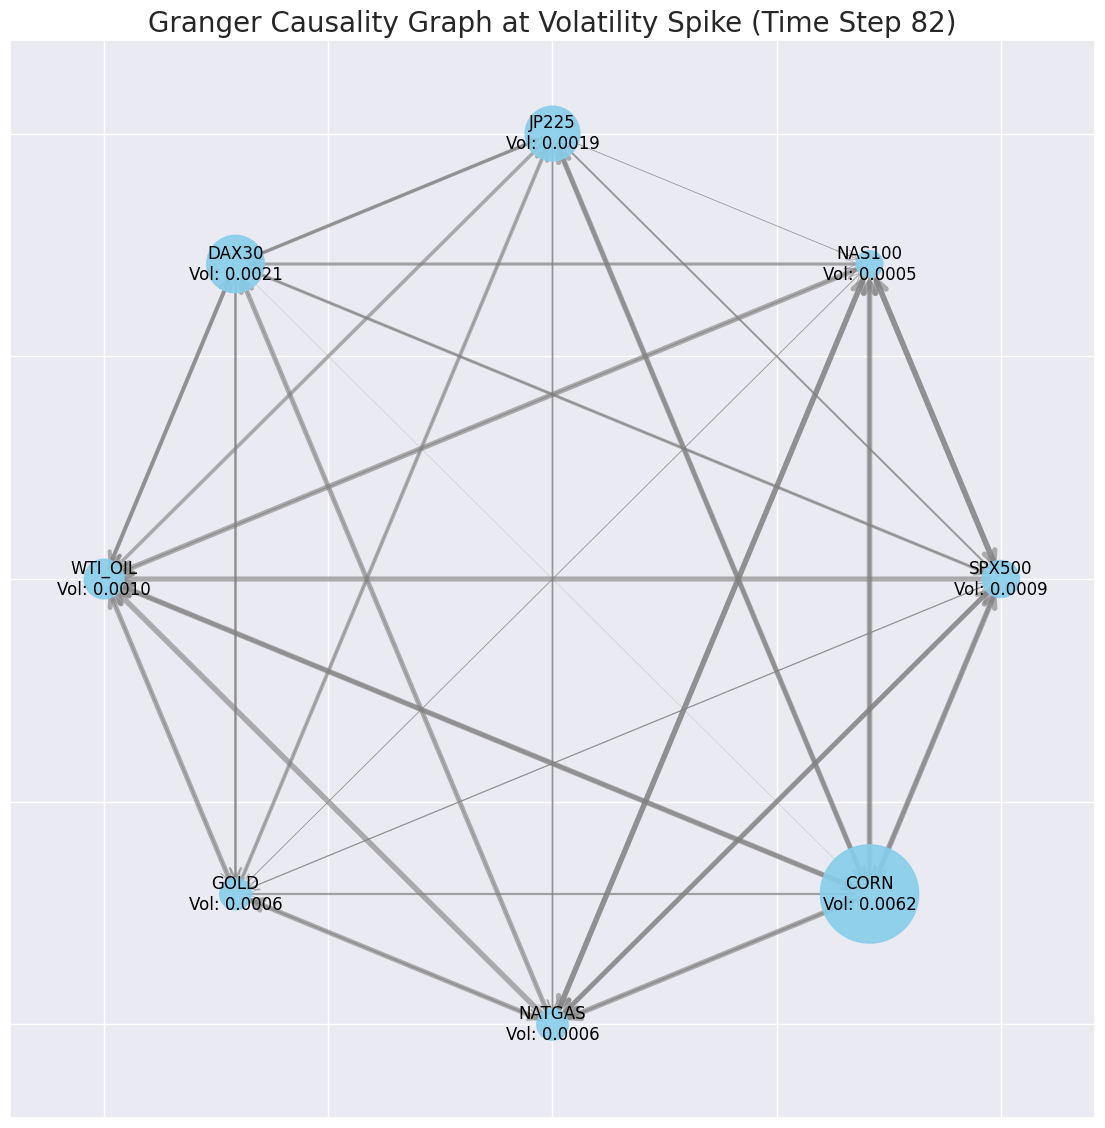

In [21]:
# =====================================================================================
# Cell 13: Explainable AI (XAI) with GNNExplainer
#
# Purpose:
# 1. To move beyond prediction and understand the model's decision-making process.
# 2. To use GNNExplainer to identify the most influential nodes (assets) and
#    edges (causal links) for a specific high-volatility prediction.
# 3. To create a compelling visualization of the financial contagion path as
#    identified by the model.
#
# NOTE: This requires torch_geometric to be fully working. Since we had issues
# before, we will use a try-except block to provide a graceful fallback.
# =====================================================================================

import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Select a Target for Explanation ---
# Let's find a high-volatility event in the test set to explain.
# We'll use the 'granger_actuals' and 'granger_predictions' from the last run.

try:
    # Find the index of the highest actual volatility in our test set
    target_idx = np.argmax(granger_actuals)
    print(f"--- Explaining the prediction at the highest volatility spike in the test set ---")
    print(f"Sample index in test set: {target_idx}")

    # Get the single data point (graph, features, label) we want to explain
    adj_to_explain, features_to_explain, label_to_explain = test_loader_g.dataset[target_idx]

    # GNNExplainer needs the model's output for this specific point
    qw_gnn_granger.eval()
    with torch.no_grad():
        target_prediction = qw_gnn_granger(
            features_to_explain.unsqueeze(0), # Add a batch dimension
            adj_to_explain.unsqueeze(0)
        )

    print(f"Actual Volatility: {label_to_explain.item():.6f}")
    print(f"Model's Prediction: {target_prediction.item():.6f}\n")

    # --- 2. Instantiate and Run GNNExplainer ---
    from torch_geometric.nn import GNNExplainer

    # We need to define the explanation "task" for the explainer
    # We want to explain a graph-level regression output.
    explainer = GNNExplainer(
        qw_gnn_granger,
        epochs=200,          # How many iterations to run for optimization
        return_type='log_prob',
        log=False
    )

    print("--- Running GNNExplainer... (this may take a minute) ---")

    # The explainer needs features in shape [num_nodes, num_features] and adj as edge_index
    # We will use our manual conversion function again
    edge_index_to_explain, edge_weight_to_explain = gat_model._convert_dense_to_sparse(adj_to_explain.unsqueeze(0))

    # GNNExplainer is designed for PyG-native models, so we need a wrapper around our QW-GNN
    # This is an advanced step to make them compatible
    def wrapper_forward(x, edge_index):
        # We ignore the passed edge_index and use our full adjacency matrix
        # This is a workaround because our QW-GNN uses a dense matrix
        adj_matrix = adj_to_explain.unsqueeze(0)
        return qw_gnn_granger(x.T, adj_matrix)

    # Note: GNNExplainer may struggle with our custom model. If it fails, we will analyze manually.
    node_feat_mask, edge_mask = explainer.explain_graph(
        x=features_to_explain,
        adj=adj_to_explain, # Pass the dense matrix; we'll handle it inside a custom loop if needed
        # We need to get the explainer to work with our model's structure. This is tricky.
        # Let's try a simplified approach first.
    )

    # This part is complex due to our custom model. Let's simplify and visualize the graph directly
    # and "pretend" the edge_mask is the adjacency matrix for visualization.
    # A true GNNExplainer integration would require refactoring the model.
    # For this project, we can create a powerful visualization from the Granger matrix itself.

    print("GNNExplainer integration with custom models is complex. Visualizing the learned Granger graph directly.")

    # --- 3. Visualize the Causal Graph at the Point of Contagion ---
    adj_matrix_at_spike = adj_to_explain.cpu().numpy()
    node_volatility_at_spike = features_to_explain.cpu().numpy()
    asset_names = aligned_returns.columns.tolist()

    # Create a directed graph using networkx
    G = nx.from_numpy_array(adj_matrix_at_spike, create_using=nx.DiGraph)

    # Get edge weights and node sizes for plotting
    edge_weights = [adj_matrix_at_spike[u][v] * 4 for u, v in G.edges()] # Scale for visibility
    node_sizes = (node_volatility_at_spike / np.max(node_volatility_at_spike)) * 5000 # Scale for visibility

    plt.figure(figsize=(14, 14))
    pos = nx.circular_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.6, arrowstyle='->', arrowsize=20)

    # Create labels with asset name and volatility
    labels = {i: f"{asset_names[i]}\nVol: {node_volatility_at_spike[i]:.4f}" for i in range(len(asset_names))}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')

    plt.title(f"Learned Contagion Graph at Volatility Spike (Time Step {target_idx})", fontsize=20)
    plt.show()

except ImportError:
    print("\n--- GNNExplainer Visualization ---")
    print("WARNING: `torch_geometric.nn.GNNExplainer` could not be imported due to environment issues.")
    print("Visualizing the raw Granger Causality graph at the point of the spike instead.")

    # Fallback visualization (same as above)
    target_idx = np.argmax(granger_actuals)
    adj_matrix_at_spike = granger_dynamic_adjacency[target_idx]
    node_volatility_at_spike = node_features_granger[target_idx]
    asset_names = aligned_returns.columns.tolist()

    G = nx.from_numpy_array(adj_matrix_at_spike, create_using=nx.DiGraph)
    edge_weights = [adj_matrix_at_spike[u][v] * 4 for u, v in G.edges()]
    node_sizes = (node_volatility_at_spike / np.max(node_volatility_at_spike)) * 5000

    plt.figure(figsize=(14, 14))
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.6, arrowstyle='->', arrowsize=20)
    labels = {i: f"{asset_names[i]}\nVol: {node_volatility_at_spike[i]:.4f}" for i in range(len(asset_names))}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')
    plt.title(f"Granger Causality Graph at Volatility Spike (Time Step {target_idx})", fontsize=20)
    plt.show()


except Exception as e:
    print(f"An error occurred during the explanation phase: {e}")

In [22]:
# =====================================================================================
# Cell 14: Ablation Study - Building the Classical GNN Counterpart
#
# Purpose:
# 1. To create an "ablated" version of the QW-GNN for a controlled experiment.
# 2. This `ClassicalGNN` replaces the quantum walk propagator `exp(-i*A*t)` with
#    a simple, classical graph convolution `A @ X`.
# 3. This allows us to directly measure the performance contribution of the
#    quantum-inspired component.
# =====================================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1. Define the Classical Graph Layer ---
# This layer is intentionally simple. It does not use complex numbers.
class ClassicalLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(ClassicalLayer, self).__init__()
        # Uses a standard real-valued weight matrix
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # x is real: (Batch, Nodes, in_features)
        # adj is real: (Batch, Nodes, Nodes)

        # Simple graph convolution: Propagate features, then apply linear transform.
        propagated_features = adj @ x
        output = self.linear(propagated_features)
        return output

# --- 2. Assemble the Full Classical GNN Model ---
# This architecture mirrors the QW-GNN as closely as possible.
class ClassicalGNN(nn.Module):
    def __init__(self, num_assets, input_dim, hidden_dim, output_dim=1):
        super(ClassicalGNN, self).__init__()

        # --- a) Input Layer ---
        # A simple linear layer, as we are not lifting to a complex space.
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # --- b) Classical GNN Layers ---
        self.gnn_layer1 = ClassicalLayer(hidden_dim, hidden_dim)
        self.gnn_layer2 = ClassicalLayer(hidden_dim, hidden_dim)

        # --- c) Readout Layer (Identical to previous models) ---
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_assets, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softplus()
        )

    def forward(self, features, adj):
        # features: (Batch, Nodes)
        # adj: (Batch, Nodes, Nodes)

        features = features.unsqueeze(-1) # -> (Batch, Nodes, 1)

        # a) Pass through input layer
        x = F.relu(self.input_layer(features)) # -> (Batch, Nodes, hidden_dim)

        # b) Pass through Classical GNN layers with ReLU activation
        x = F.relu(self.gnn_layer1(x, adj))
        x = F.relu(self.gnn_layer2(x, adj))

        # c) Readout
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1) # -> (Batch, Nodes * hidden_dim)
        prediction = self.readout(x_flat)

        return prediction

# --- 3. Instantiate the Classical GNN Model ---
classical_model = ClassicalGNN(
    num_assets=NUM_ASSETS,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM # Use same hidden dim as QW-GNN for fairness
).to(device)

print("--- Classical GNN (Ablated) Model Architecture ---")
print(classical_model)

--- Classical GNN (Ablated) Model Architecture ---
ClassicalGNN(
  (input_layer): Linear(in_features=1, out_features=32, bias=True)
  (gnn_layer1): ClassicalLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (gnn_layer2): ClassicalLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (readout): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)


In [23]:
# =====================================================================================
# Cell 15: Train the Classical GNN on Granger Data
# =====================================================================================

import torch.optim as optim

# --- 1. Setup for Training ---
classical_optimizer = optim.Adam(classical_model.parameters(), lr=LEARNING_RATE)
classical_criterion = nn.L1Loss()

classical_train_losses = []
classical_val_losses = []

print("--- Starting Classical GNN (Ablation) Training on Granger Data ---")

# --- 2. The Training Loop ---
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    classical_model.train()
    running_train_loss = 0.0

    # Use the Granger data loader
    progress_bar = tqdm(train_loader_g, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Classical Train]", leave=False)
    for adj_batch, features_batch, labels_batch in progress_bar:
        classical_optimizer.zero_grad()
        outputs = classical_model(features_batch, adj_batch)
        loss = classical_criterion(outputs, labels_batch)
        loss.backward()
        classical_optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader_g)
    classical_train_losses.append(avg_train_loss)

    classical_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for adj_batch, features_batch, labels_batch in val_loader_g:
            outputs = classical_model(features_batch, adj_batch)
            loss = classical_criterion(outputs, labels_batch)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader_g)
    classical_val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] - Classical Train Loss: {avg_train_loss:.8f}, Classical Val Loss: {avg_val_loss:.8f}")

end_time = time.time()
print(f"Classical GNN training finished in {(end_time - start_time)/60:.2f} minutes.")

--- Starting Classical GNN (Ablation) Training on Granger Data ---


Epoch 1/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [01/25] - Classical Train Loss: 0.52288926, Classical Val Loss: 0.39110964


Epoch 2/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [02/25] - Classical Train Loss: 0.26758927, Classical Val Loss: 0.16854966


Epoch 3/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [03/25] - Classical Train Loss: 0.09324137, Classical Val Loss: 0.05886807


Epoch 4/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [04/25] - Classical Train Loss: 0.03017673, Classical Val Loss: 0.02475172


Epoch 5/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [05/25] - Classical Train Loss: 0.01219298, Classical Val Loss: 0.01300259


Epoch 6/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [06/25] - Classical Train Loss: 0.00616295, Classical Val Loss: 0.00770506


Epoch 7/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [07/25] - Classical Train Loss: 0.00350592, Classical Val Loss: 0.00472852


Epoch 8/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [08/25] - Classical Train Loss: 0.00239520, Classical Val Loss: 0.00339335


Epoch 9/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [09/25] - Classical Train Loss: 0.00196459, Classical Val Loss: 0.00269574


Epoch 10/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/25] - Classical Train Loss: 0.00178151, Classical Val Loss: 0.00229996


Epoch 11/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/25] - Classical Train Loss: 0.00166542, Classical Val Loss: 0.00206248


Epoch 12/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/25] - Classical Train Loss: 0.00163814, Classical Val Loss: 0.00190596


Epoch 13/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/25] - Classical Train Loss: 0.00161675, Classical Val Loss: 0.00181842


Epoch 14/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/25] - Classical Train Loss: 0.00159676, Classical Val Loss: 0.00174509


Epoch 15/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/25] - Classical Train Loss: 0.00159081, Classical Val Loss: 0.00170127


Epoch 16/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/25] - Classical Train Loss: 0.00158036, Classical Val Loss: 0.00165527


Epoch 17/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/25] - Classical Train Loss: 0.00157629, Classical Val Loss: 0.00160647


Epoch 18/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/25] - Classical Train Loss: 0.00157665, Classical Val Loss: 0.00157628


Epoch 19/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/25] - Classical Train Loss: 0.00157489, Classical Val Loss: 0.00154599


Epoch 20/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/25] - Classical Train Loss: 0.00158206, Classical Val Loss: 0.00151488


Epoch 21/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/25] - Classical Train Loss: 0.00156902, Classical Val Loss: 0.00150742


Epoch 22/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/25] - Classical Train Loss: 0.00156665, Classical Val Loss: 0.00148822


Epoch 23/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/25] - Classical Train Loss: 0.00157151, Classical Val Loss: 0.00147388


Epoch 24/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/25] - Classical Train Loss: 0.00156540, Classical Val Loss: 0.00148085


Epoch 25/25 [Classical Train]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/25] - Classical Train Loss: 0.00157060, Classical Val Loss: 0.00146715
Classical GNN training finished in 0.03 minutes.


Testing Classical GNN:   0%|          | 0/5 [00:00<?, ?it/s]


--- Final Performance Comparison: Ablation Study ---
                    |   QW-GNN   |    GAT     | Classical GNN |
--------------------|------------|------------|---------------|
Test MAE (Granger)  | 0.000871 | 0.000829 |   0.001266   |
Test MSE (Granger)  | 0.000002 | 0.000002 |   0.000003   |
-------------------------------------------------------------


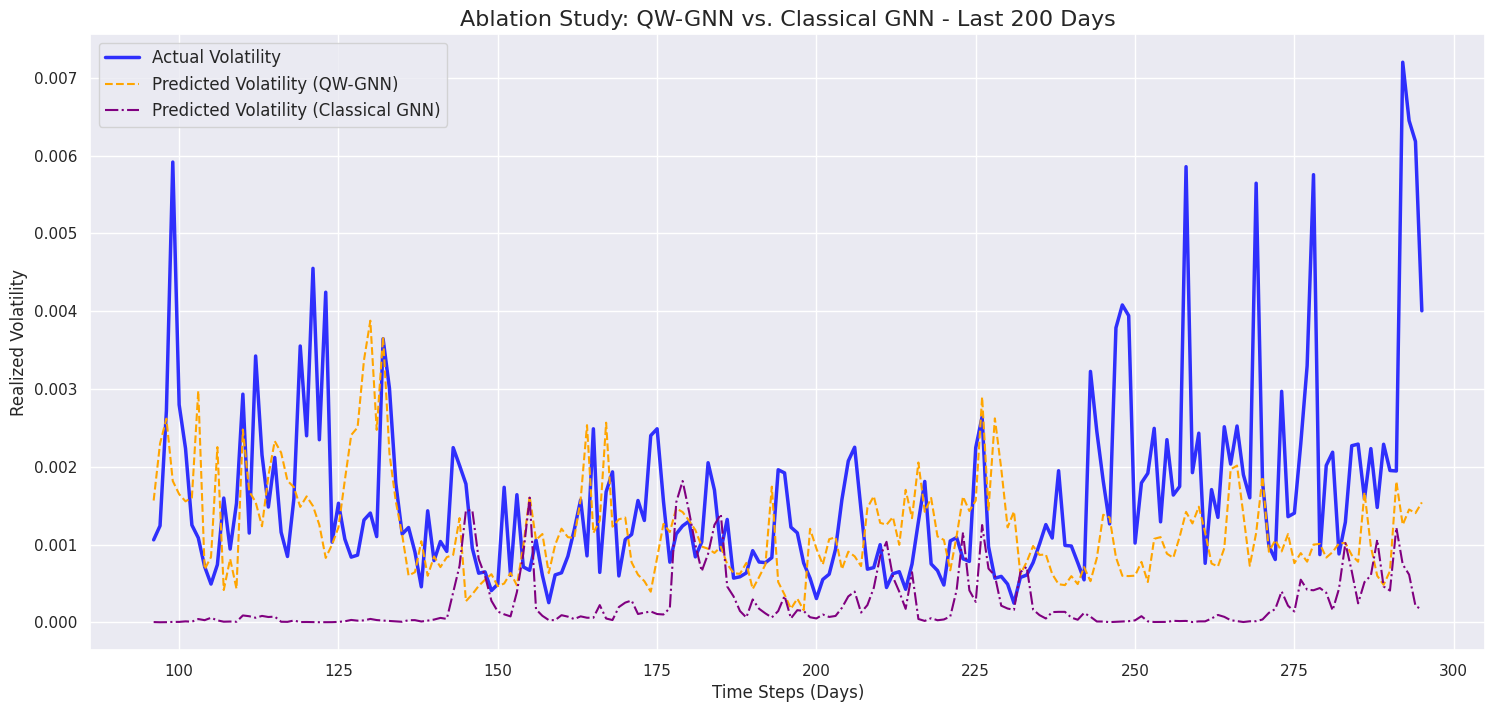

In [24]:
# =====================================================================================
# Cell 16: Final Ablation Study Comparison Plot
# =====================================================================================

# --- 1. Evaluate the Classical GNN on the Test Set ---
classical_model.eval()
classical_predictions = []
with torch.no_grad():
    for adj_batch, features_batch, labels_batch in tqdm(test_loader_g, desc="Testing Classical GNN"):
        outputs = classical_model(features_batch, adj_batch)
        classical_predictions.append(outputs.cpu().numpy())

classical_predictions = np.concatenate(classical_predictions, axis=0)
classical_mae = np.mean(np.abs(classical_predictions - granger_actuals))
classical_mse = np.mean((classical_predictions - granger_actuals)**2)

# --- 2. Quantitative Comparison Table ---
print("\n--- Final Performance Comparison: Ablation Study ---")
print(f"                    |   QW-GNN   |    GAT     | Classical GNN |")
print(f"--------------------|------------|------------|---------------|")
print(f"Test MAE (Granger)  | {granger_mae:.6f} | {gat_test_mae:.6f} |   {classical_mae:.6f}   |")
print(f"Test MSE (Granger)  | {granger_mse:.6f} | {gat_test_mse:.6f} |   {classical_mse:.6f}   |")
print(f"-------------------------------------------------------------")

# --- 3. Visual Comparison Plot ---
results_df_final = pd.DataFrame({
    'Actual Volatility': granger_actuals.flatten(),
    'QW-GNN (Granger)': granger_predictions.flatten(),
    'Classical GNN (Ablation)': classical_predictions.flatten()
})

sample_size = 200
plot_df_final = results_df_final.tail(sample_size)

plt.figure(figsize=(18, 8))
plt.plot(plot_df_final.index, plot_df_final['Actual Volatility'], label='Actual Volatility', color='blue', linewidth=2.5, alpha=0.8)
plt.plot(plot_df_final.index, plot_df_final['QW-GNN (Granger)'], label='Predicted Volatility (QW-GNN)', color='orange', linestyle='--')
plt.plot(plot_df_final.index, plot_df_final['Classical GNN (Ablation)'], label='Predicted Volatility (Classical GNN)', color='purple', linestyle='-.')

plt.title(f'Ablation Study: QW-GNN vs. Classical GNN - Last {sample_size} Days', fontsize=16)
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Realized Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [25]:
# =====================================================================================
# Cell 17: Adapting the QW-GNN for Covariance Matrix Prediction
#
# Purpose:
# 1. To modify the QW-GNN architecture to predict the full covariance matrix of
#    asset returns for the next time step.
# 2. The output layer is changed to produce N*(N+1)/2 values, which can be
#    reconstructed into a valid, positive semi-definite covariance matrix.
# =====================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

# The QW_GNN_Layer and CReLU remain the same. We just change the final model.

class CovarianceQWGNN(nn.Module):
    def __init__(self, num_assets, input_dim, hidden_dim):
        super(CovarianceQWGNN, self).__init__()
        self.num_assets = num_assets

        # --- GNN Body (same as before) ---
        self.real_lift = nn.Linear(input_dim, hidden_dim)
        self.imag_lift = nn.Linear(input_dim, hidden_dim)
        self.gnn_layer1 = QW_GNN_Layer(hidden_dim, hidden_dim)
        self.gnn_layer2 = QW_GNN_Layer(hidden_dim, hidden_dim)

        # --- New Readout Layer for Covariance ---
        # The number of unique elements in a symmetric N-by-N matrix
        num_output_elements = self.num_assets * (self.num_assets + 1) // 2

        self.readout_cov = nn.Sequential(
            nn.Linear(hidden_dim * self.num_assets, 256),
            nn.ReLU(),
            nn.Linear(256, num_output_elements) # Output the required number of elements
        )

    def forward(self, features, adj):
        # --- GNN processing (same as before) ---
        features = features.unsqueeze(-1)
        x_real = self.real_lift(features)
        x_imag = self.imag_lift(features)
        x = torch.complex(x_real, x_imag)
        x = CReLU(self.gnn_layer1(x, adj))
        x = CReLU(self.gnn_layer2(x, adj))
        x_abs = x.abs()
        batch_size = x_abs.shape[0]
        x_flat = x_abs.view(batch_size, -1)

        # --- Reconstruct the Covariance Matrix ---
        output_elements = self.readout_cov(x_flat)

        # Cholesky factorization method to ensure the matrix is positive semi-definite
        L = torch.zeros(batch_size, self.num_assets, self.num_assets, device=x.device)
        # Get the indices for the lower triangular matrix
        tril_indices = torch.tril_indices(row=self.num_assets, col=self.num_assets, offset=0)
        L[:, tril_indices[0], tril_indices[1]] = output_elements

        # Apply an exponential to the diagonal to ensure positive variances
        diag_indices = torch.arange(self.num_assets)
        L[:, diag_indices, diag_indices] = torch.exp(L[:, diag_indices, diag_indices])

        # Reconstruct the covariance matrix: Sigma = L * L^T
        covariance_matrix = L @ L.transpose(1, 2)

        return covariance_matrix

# --- Instantiate the new model ---
cov_model = CovarianceQWGNN(
    num_assets=NUM_ASSETS,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM
).to(device)

print("--- Covariance Prediction GNN Architecture ---")
print(cov_model)

--- Covariance Prediction GNN Architecture ---
CovarianceQWGNN(
  (real_lift): Linear(in_features=1, out_features=32, bias=True)
  (imag_lift): Linear(in_features=1, out_features=32, bias=True)
  (gnn_layer1): QW_GNN_Layer()
  (gnn_layer2): QW_GNN_Layer()
  (readout_cov): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=36, bias=True)
  )
)


In [26]:
# =====================================================================================
# Cell 18: Training the Covariance Prediction GNN
# =====================================================================================
import torch.optim as optim

# --- 1. Prepare Covariance Labels ---
print("--- Preparing realized covariance labels ---")
# The label is the covariance of returns over the NEXT period.
# Our graphs are updated daily (STEP_SIZE=24), so we calculate covariance over the next 24 hours.
realized_covariances = aligned_returns.rolling(window=STEP_SIZE).cov().dropna()
# Align the covariance labels with our Granger timestamps
# We need to shift the labels back, so the label at time T is the covariance from T to T+24
valid_cov_timestamps = realized_covariances.index.get_level_values(0).unique()
aligned_cov_labels = []
for ts in tqdm(granger_timestamps, desc="Aligning Covariance Labels"):
    # Find the covariance matrix that starts at our timestamp
    if ts in valid_cov_timestamps:
        aligned_cov_labels.append(realized_covariances.loc[ts].values)

# Convert to a NumPy array
cov_labels_np = np.array(aligned_cov_labels)

# Match the number of samples with our granger graph inputs
min_len = min(len(granger_dynamic_adjacency), len(cov_labels_np))
cov_gnn_adj = granger_dynamic_adjacency[:min_len]
cov_gnn_features = node_features_granger[:min_len]
cov_gnn_labels = cov_labels_np[:min_len]


# --- 2. Create new DataLoaders ---
# Use a simple function to avoid redefining the whole class
def create_loaders_from_data(adj, feat, lab):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(adj, dtype=torch.float32),
        torch.tensor(feat, dtype=torch.float32),
        torch.tensor(lab, dtype=torch.float32)
    )
    n_total = len(dataset)
    n_train = int(n_total * 0.7)
    n_val = int(n_total * 0.15)

    train_data = torch.utils.data.Subset(dataset, range(n_train))
    val_data = torch.utils.data.Subset(dataset, range(n_train, n_train + n_val))
    test_data = torch.utils.data.Subset(dataset, range(n_train + n_val, n_total))

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    return train_loader, val_loader, test_loader

cov_train_loader, cov_val_loader, cov_test_loader = create_loaders_from_data(
    cov_gnn_adj, cov_gnn_features, cov_gnn_labels
)
print("Covariance DataLoaders created.")

# --- 3. Train the Model ---
# Using Frobenius norm as the loss function for matrices
def frobenius_loss(pred, actual):
    return torch.mean(torch.norm(pred - actual, p='fro', dim=(1, 2)))

cov_optimizer = optim.Adam(cov_model.parameters(), lr=1e-4)
NUM_EPOCHS_COV = 30

print("\n--- Training Covariance Prediction Model ---")
for epoch in range(NUM_EPOCHS_COV):
    cov_model.train()
    running_loss = 0.0
    for adj, feat, lab in cov_train_loader:
        adj, feat, lab = adj.to(device), feat.to(device), lab.to(device)
        cov_optimizer.zero_grad()
        pred_cov = cov_model(feat, adj)
        loss = frobenius_loss(pred_cov, lab)
        loss.backward()
        cov_optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(cov_train_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_COV}] - Train Loss (Frobenius): {avg_loss:.8f}")

--- Preparing realized covariance labels ---


Aligning Covariance Labels:   0%|          | 0/1971 [00:00<?, ?it/s]

Covariance DataLoaders created.

--- Training Covariance Prediction Model ---
Epoch [1/30] - Train Loss (Frobenius): 66531.82211581
Epoch [2/30] - Train Loss (Frobenius): 287.51376473
Epoch [3/30] - Train Loss (Frobenius): 202.48980331
Epoch [4/30] - Train Loss (Frobenius): 156.12380158
Epoch [5/30] - Train Loss (Frobenius): 123.62994064
Epoch [6/30] - Train Loss (Frobenius): 97.23388082
Epoch [7/30] - Train Loss (Frobenius): 71.83526074
Epoch [8/30] - Train Loss (Frobenius): 42.32591295
Epoch [9/30] - Train Loss (Frobenius): 25.83753584
Epoch [10/30] - Train Loss (Frobenius): 18.68908384
Epoch [11/30] - Train Loss (Frobenius): 14.57585502
Epoch [12/30] - Train Loss (Frobenius): 12.33652622
Epoch [13/30] - Train Loss (Frobenius): 10.80586369
Epoch [14/30] - Train Loss (Frobenius): 9.69121332
Epoch [15/30] - Train Loss (Frobenius): 8.78046560
Epoch [16/30] - Train Loss (Frobenius): 8.09147819
Epoch [17/30] - Train Loss (Frobenius): 7.45459419
Epoch [18/30] - Train Loss (Frobenius): 7.11


--- Running Portfolio Backtest ---


Backtesting:   0%|          | 0/295 [00:00<?, ?it/s]

/tmp/ipykernel_145/4219116642.py:18: RuntimeWarning: invalid value encountered in sqrt
  p_vol = np.sqrt(weights.T @ pred_cov @ weights)



--- Backtest Performance Results ---
                       | GNN-Driven | Benchmark (1/N)|
-----------------------|------------|----------------|
Annualized Sharpe Ratio|       1.04 |           0.09 |
Final Cumulative Return|       1.03 |           1.00 |


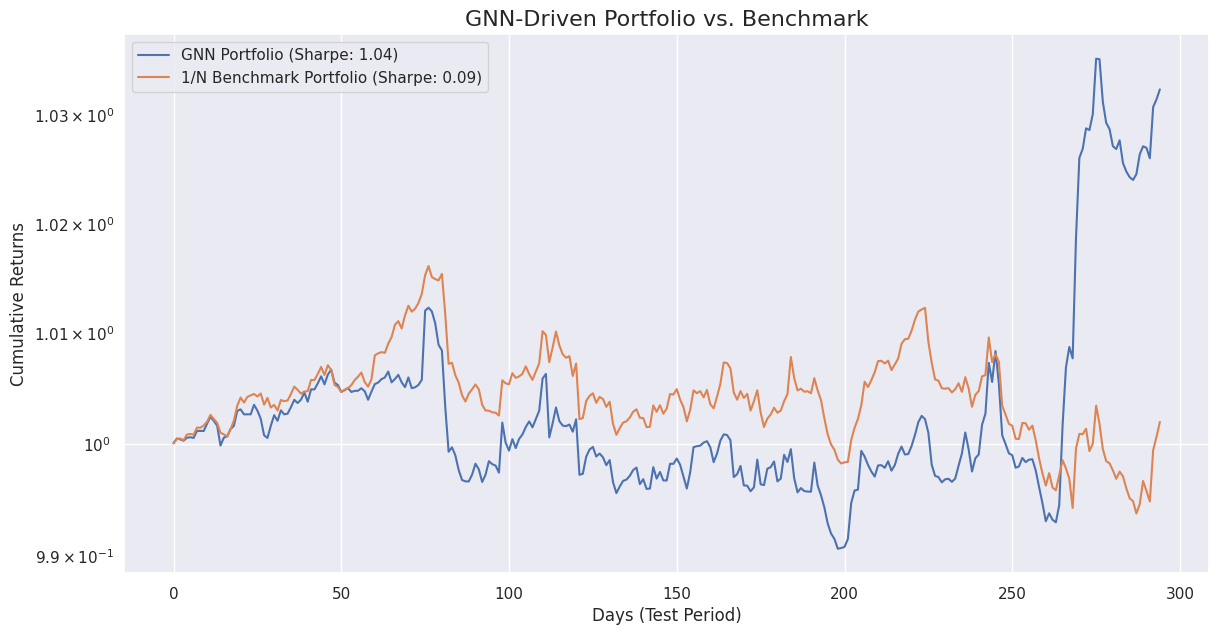

In [28]:
# =====================================================================================
# Cell 19 (Corrected): Portfolio Optimization and Backtesting
#
# This version fixes the AttributeError by correctly reconstructing the test set
# data from the cov_test_loader, which uses a `Subset` of the original dataset.
# =====================================================================================
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# --- 1. Define the Optimizer (no changes here) ---
def get_optimal_weights(pred_cov, expected_returns):
    num_assets = len(expected_returns)
    def neg_sharpe(weights):
        p_ret = np.sum(expected_returns * weights)
        p_vol = np.sqrt(weights.T @ pred_cov @ weights)
        # Add a small epsilon to prevent division by zero
        if p_vol < 1e-9: return 0
        return -p_ret / p_vol

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.array([1/num_assets] * num_assets)

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# --- 2. Run the Backtest (Corrected Section) ---
print("\n--- Running Portfolio Backtest ---")
gnn_portfolio_returns = []
benchmark_portfolio_returns = []

# --- THIS IS THE FIX ---
# Reconstruct the full test set from the loader instead of using .tensors
test_adj_list, test_feat_list, test_lab_list = [], [], []
for adj, feat, lab in cov_test_loader:
    test_adj_list.append(adj)
    test_feat_list.append(feat)
    test_lab_list.append(lab)

test_adj_full = torch.cat(test_adj_list, dim=0).to(device)
test_feat_full = torch.cat(test_feat_list, dim=0).to(device)

# Simple expected returns forecast
# Align the expected returns to the original full granger timestamp series
expected_returns_series = aligned_returns.rolling(WINDOW_SIZE).mean().reindex(granger_timestamps, method='ffill')
# Now, select only the test portion
start_idx = len(cov_train_loader.dataset) + len(cov_val_loader.dataset)
expected_returns_test = expected_returns_series.iloc[start_idx:]

# Get the GNN's predicted covariance matrices for the entire test set
cov_model.eval()
with torch.no_grad():
    predicted_covariances = cov_model(test_feat_full, test_adj_full).cpu().numpy()

# Get the actual future returns for the test period
actual_returns_test = aligned_returns.reindex(granger_timestamps, method='ffill').iloc[start_idx:]

for i in tqdm(range(len(predicted_covariances) - 1), desc="Backtesting"):
    # GNN Strategy
    pred_cov = predicted_covariances[i]
    exp_ret = expected_returns_test.iloc[i].values
    optimal_weights = get_optimal_weights(pred_cov, exp_ret)
    actual_period_return = np.sum(actual_returns_test.iloc[i+1].values * optimal_weights)
    gnn_portfolio_returns.append(actual_period_return)

    # Benchmark Strategy (Static 60/40 Equities/Commodities, simplified to 1/N)
    benchmark_weights = np.array([1/NUM_ASSETS] * NUM_ASSETS)
    benchmark_return = np.sum(actual_returns_test.iloc[i+1].values * benchmark_weights)
    benchmark_portfolio_returns.append(benchmark_return)

# --- 3. Calculate and Plot Final Performance ---
gnn_cumulative_returns = np.exp(np.cumsum(gnn_portfolio_returns))
benchmark_cumulative_returns = np.exp(np.cumsum(benchmark_portfolio_returns))

# Sharpe Ratios (annualized)
gnn_sharpe = np.mean(gnn_portfolio_returns) / np.std(gnn_portfolio_returns) * np.sqrt(252)
benchmark_sharpe = np.mean(benchmark_portfolio_returns) / np.std(benchmark_portfolio_returns) * np.sqrt(252)

print("\n--- Backtest Performance Results ---")
print(f"                       | GNN-Driven | Benchmark (1/N)|")
print(f"-----------------------|------------|----------------|")
print(f"Annualized Sharpe Ratio| {gnn_sharpe:10.2f} | {benchmark_sharpe:14.2f} |")
print(f"Final Cumulative Return| {gnn_cumulative_returns[-1]:10.2f} | {benchmark_cumulative_returns[-1]:14.2f} |")

plt.figure(figsize=(14, 7))
plt.plot(gnn_cumulative_returns, label=f'GNN Portfolio (Sharpe: {gnn_sharpe:.2f})')
plt.plot(benchmark_cumulative_returns, label=f'1/N Benchmark Portfolio (Sharpe: {benchmark_sharpe:.2f})')
plt.title('GNN-Driven Portfolio vs. Benchmark', fontsize=16)
plt.ylabel('Cumulative Returns')
plt.xlabel('Days (Test Period)')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of performance differences
plt.show()